## Importing Packages

In [1]:
from tensorflow.keras import Model as Model_
from tensorflow.keras.layers import Input, ReLU, LSTM, GRU, SimpleRNN, Dense, TimeDistributed, Bidirectional, GaussianNoise 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf
import tensorflow_model_remediation.min_diff.losses.mmd_loss as MMD

import matplotlib.pyplot as plt
from itertools import chain
import pandas as pd
import numpy as np
import imageio
import os
import re
import pickle

print(tf.__version__)

2.9.0


## Dataset Reading and Preprocessing

### Listing all the movable joints in the human skeleton

In [2]:
#Was done in the preprocessing in [1]
# Joints in H3.6M -- data has 32 joints, but only 17 that move; these are the indices.
H36M_NAMES = ['']*32
H36M_NAMES[0]  = 'Hip'
H36M_NAMES[1]  = 'RHip'
H36M_NAMES[2]  = 'RKnee'
H36M_NAMES[3]  = 'RFoot'
H36M_NAMES[6]  = 'LHip'
H36M_NAMES[7]  = 'LKnee'
H36M_NAMES[8]  = 'LFoot'
H36M_NAMES[12] = 'Spine'
H36M_NAMES[13] = 'Thorax'
H36M_NAMES[14] = 'Neck/Nose'
H36M_NAMES[15] = 'Head'
H36M_NAMES[17] = 'LShoulder'
H36M_NAMES[18] = 'LElbow'
H36M_NAMES[19] = 'LWrist'
H36M_NAMES[25] = 'RShoulder'
H36M_NAMES[26] = 'RElbow'
H36M_NAMES[27] = 'RWrist'

### A class to Read and Combine all the Dataset files

In [3]:
class Dataset_loading:
    def __init__(self, dir_path, include_dimension = 2, sample_size = 50, 
                 total_classes = 17, datatype = 'float32', include_movable_joints = False, batch_size = 20, 
                 include_action_labels = True, return_action_labels = False):
        
        #Dataset Directory path
        self.dir_path = dir_path
        
        #Which Dimension file to include, possible values: 2 and 3
        self.include_dimension = include_dimension
        
        #Total frames in one Sample
        self.sample_size = sample_size
        
        #Default Datatype for all the samples
        self.datatype = datatype
        
        #Batch Size of the dataset for experimentation 
        self.batch_size = batch_size
        
        #Boolean value to indicate whether to include action class in each frames
        self.include_action_labels = include_action_labels
        
        #Whether to return action labels with data
        self.return_action_labels = return_action_labels
        
        #Activity classes to include
        self.classes = ['SittingDown', 'Walking', 'Directions', 'Discussion', 'Sitting', 'Phoning', 'Eating', 'Posing', 'Greeting', 'Smoking']
        
        #Total activity classes
        self.total_classes = len(self.classes)
        
        #Subject Folders names in the Dataset
        self.internal_folders = ['S1', 'S5','S6','S7','S8','S9','S11']

        #Boolean value indicating whether to include all joints or only the movable joints.
        self.include_movable_joints = include_movable_joints
        
        self.movable_joints = [0, 1, 2, 3, 6, 7, 8, 12, 13, 14, 15, 17, 18, 19, 25, 26, 27]
    
    def read_dataset(self):
        try:
            #Contains all the different activity vectors
            activity_vector = {}
            
            #Contains the overall dataset
            sampled_data = None
            sampled_labels = None
            
            #Based on dimensions, which folder to use for extracting the dataset files
            data_folder = 'Poses_D2_Positions' if self.include_dimension == 2 else 'Poses_D3_Positions'
            
            #Checking if the dataset path is valid
            if not os.path.exists(self.dir_path):
                print('The Data Directory Does not Exist!')
                return None

            #Iterating over all the subject folders
            for fld in self.internal_folders:
                #Iterating for each file in the specified folder
                for file in os.listdir(os.path.join(self.dir_path, fld, data_folder)):
                    #Extracting the activity from the filename
                    activity = self.__extract_activity(file)
                    
                    if activity not in self.classes:
                        continue
                    
                    #Reading the CSV file using Pandas
                    data = pd.read_csv(os.path.join(self.dir_path, fld, data_folder, file), header=None)

                    #Formulating the activity vector using one hot encoding
                    if activity not in activity_vector:
                        total_keys = len(activity_vector.keys())
                        activity_vector[activity] = np.zeros(self.total_classes)
                        activity_vector[activity][total_keys] = 1
                    vector = activity_vector[activity]
                    
                    #Sampling the dataset
                    grouped_sample, grouped_activity = self.__group_samples(data, self.sample_size, vector)
                    sampled_data = grouped_sample if sampled_data is None else np.append(sampled_data, grouped_sample, axis=0)
                    sampled_labels = grouped_activity if sampled_labels is None else np.append(sampled_labels, grouped_activity, axis=0)
            
            #Changing the Datatype
            sampled_data = sampled_data.astype(self.datatype)
            
            #To make the data divisible for batch size
            total_batches = sampled_data.shape[0]
            sampled_data = sampled_data[:total_batches - (total_batches % self.batch_size)]
            sampled_labels = sampled_labels[:total_batches - (total_batches % self.batch_size)]
            
            if self.return_action_labels:
                return sampled_data, sampled_labels
            
            return sampled_data
        except Exception as e:
            print(e)
    
    def __extract_activity(self, filename):
        try:
            #Extracting the filename and excluding the extension
            name = os.path.splitext(filename)[0]
            
            #Substituting the empty string with characters other than english alphabets
            activity = re.sub('[^A-Za-z]+' , '' , name)
            return activity
        except Exception as e:
            print(e)
    
    def __group_samples(self, dataset, sample_size, activity):
        try:
            #Checking if the dataset is a Pandas Dataframe
            if not isinstance(dataset, pd.DataFrame):
                print('Expecting Pandas Dataframe, but got {}'.format(type(dataset)))
                return None
            
            if self.include_movable_joints:
                joints = list(chain.from_iterable((jt*2, (jt*2)+1) for jt in self.movable_joints))
                dataset = dataset.iloc[: , joints].copy()

            #Appending activity class to each row in the dataset
            if self.include_action_labels:
                dataset = pd.concat([dataset, pd.DataFrame(np.tile(activity, (dataset.shape[0],1)))], axis=1)
            
            #Reshaping the dataset into sample batches
            total_samples = dataset.shape[0]//sample_size
            total_features = dataset.shape[1]
            grouped_rows = dataset.to_numpy()[:total_samples*self.sample_size].reshape((-1,self.sample_size, total_features))
            
            grouped_activity = np.tile(activity, (dataset.shape[0]//self.sample_size, 1))
            grouped_activity = grouped_activity[:total_samples*self.sample_size].reshape((-1, len(activity)))
            
            return grouped_rows, grouped_activity
        except Exception as e:
            print(e)

### A function to split Dataset into Features and Labels

In [4]:
def split_to_features_labels(dataset, input_sequance_size=10, total_features=64):
    """
    Function for splitting the data into features(with sequance size=iput_sequance_size)
    and labels which should be the remainder of the sample length 
    """
    assert input_sequance_size < dataset.shape[1], f"input sequence should be smaller than the total sample size"
    
    #Dividing the dataset into features and labels by splitting the Time Frame Dimension
    features = dataset[:, np.s_[0:input_sequance_size], :]
    labels = dataset[:,np.s_[input_sequance_size:], :total_features]
    
    return features, labels

### A function for downsampling the dataset on number of frames

In [5]:
def downsampling(sampled_data, downsample_technique = 'skip'):
    """
    The function used to down-sample the data using two different techniques. In Skip, one frame is skipped consecutively and
    in the mean technique, two frames are averaged consecutively.
    """
    
    assert downsample_technique in ['skip', 'mean'], f"Only Skip and Mean techniques are available"
    
    #Creating an empty variable to store Downsampled data when the technique is Mean
    samples_per_batch = int(sampled_data.shape[1] / 2)
    total_features = sampled_data.shape[2]
    downsampled_data = np.empty(shape=(0, samples_per_batch, total_features))
    
    #In Skip technique, we skip 2 frames consecutively.
    if downsample_technique == 'skip':
        downsampled_data = sampled_data[:,::2,:]
    else:
        #Iterating over batches
        for batch in sampled_data:
    
            averaged_batch = np.empty(shape=(0, total_features))
    
            #In each iteration, averaging 2 Frames and appending it to the variable
            for i in range(0, batch.shape[0], 2):
                averaged_batch = np.append(averaged_batch, np.mean(batch[i:i+2, :], axis = 0).reshape((1, total_features)), axis = 0)
            
            #Appending the whole batched averaged downsampled data to the new variable created before
            downsampled_data = np.append(downsampled_data, averaged_batch.reshape((1, samples_per_batch, total_features)), axis = 0)
    
    return downsampled_data

### Adding more preprocessing steps (Normalization and gussian noise)

In [6]:
def preprocess_data(sampled_dataX, sampled_dataY, normalize=True, add_noise=True
                    , stddev=0.05, augmentation = False) :
    """
    Function to preprocess data by normalizing input features and adding guassian
    noise to increase model robustness
    """
    original_sampled_dataX = sampled_dataX.copy()
    class_labels = sampled_dataX[:, :, -10:]
    sampled_dataX = sampled_dataX[:,:,:-10]
    
    if normalize :
        sampled_dataX =  tf.keras.utils.normalize(sampled_dataX, axis=2)
    
    if add_noise :
        guassian_noise_layer = tf.keras.layers.GaussianNoise(stddev=stddev)
        sampled_dataX = guassian_noise_layer(sampled_dataX)
        
    sampled_dataX = np.append(sampled_dataX, class_labels, axis=2)
    
    if augmentation:
        sampled_dataX = np.append(original_sampled_dataX, sampled_dataX, axis=0)
        sampled_dataY = np.append(sampled_dataY, sampled_dataY, axis=0)
    
    return sampled_dataX, sampled_dataY

## Defining different components of the model

### Defining the Interpolation Layer

In [7]:
class InterpolationLayer(tf.keras.layers.Layer):
    """
    Custom interpolation layer extending the keras layer class
    it has one attribute num_frames to be interpolated between each two consecutive 
    timesteps
    it has one main function interpolateFrames  
    """
  
    def __init__(self, num_frames=5):
        super(InterpolationLayer, self).__init__()
        self.num_frames = num_frames

    def interpolateFrames(self, inputs):
        """
        Takes input tensors of shape(batch_size, timesteps, features)
        returns interpolated frames with shape(batch_size, timesteps*num_frames, features)
        """
        
        batch_size = inputs.shape[0]
        timesteps = inputs.shape[1]
        features = inputs.shape[2]
        interpolated_frames = tf.zeros([0, features])
        
        for batch in tf.range(tf.shape(inputs)[0]) :
            tf.autograph.experimental.set_loop_options(
            shape_invariants=[(interpolated_frames, tf.TensorShape([None, features]))])
            for t in range(timesteps) :
                for j in range(self.num_frames) :
                    X_i0 = inputs[batch, t]
                    if(t == timesteps-1) :
                        X_i1 = inputs[batch, t]
                    else :  
                        X_i1 = inputs[batch, t+1]
                    alpha_j = j/self.num_frames
                    current_frame = alpha_j*X_i0 + (1-alpha_j)*X_i1
                    current_frame = tf.reshape(current_frame, [1, features])
                    interpolated_frames = tf.concat((interpolated_frames, current_frame), axis=0)

        interpolated_frames = tf.reshape(interpolated_frames,[tf.shape(inputs)[0], (timesteps)*self.num_frames, features])
        return interpolated_frames

    def call(self, inputs):
        return self.interpolateFrames(inputs)

### Trying to create the Keras GlocalNet model through a custom function

In [8]:
def create_glocalNet_model(enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, input_diminsions=74, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False) :
    #Glogen encoder
    encoder_inputs = Input(shape=(10, input_diminsions))
    encoder = Bidirectional(LSTM(enocder_hidden_state, return_sequences=True, return_state=True))
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    #Glogen decoder
    decoder_lstm = Bidirectional(LSTM(decoder_hidden_state, return_sequences=True, return_state=True))
    decoder_outputs, _, _ = decoder_lstm(encoder_outputs,
                                        initial_state=encoder_states)
    decoder_dense = TimeDistributed(Dense(output_diminsion, activation=dense_activation))
    decoder_outputs = decoder_dense(decoder_outputs)

    #Interpolation layer
    interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
    interpolation_output = interpolation_layer(decoder_outputs)
    #return the model if execlude_locgen is true
    if(exclude_locgen) :
        return Model_(encoder_inputs, interpolation_output)
    
    #Locgen encoder
    encoder_locgen = Bidirectional(LSTM(enocder_hidden_state, return_sequences=True, return_state=True))
    encoder_outputs_locgen, state_h_locgen, state_c_locgen = encoder_locgen(interpolation_output)
    encoder_states_locgen = [state_h_locgen, state_c_locgen]
    #Locgen decoder
    decoder_lstm_locgen = Bidirectional(LSTM(decoder_hidden_state, return_sequences=True, return_state=True))
    decoder_outputs_locgen, _, _ = decoder_lstm(encoder_outputs_locgen,
                                        initial_state=encoder_states_locgen)
    decoder_dense_locgen = TimeDistributed(Dense(output_diminsion, activation=dense_activation))
    glocalNet_output = decoder_dense_locgen(decoder_outputs_locgen)
    return Model_(encoder_inputs, glocalNet_output)


### Custom GlocalNet class

In [9]:
class GlocalNet(Model_):
    """
    A full GlocalNet implementation include the three main stages
    Glogen generating initial sparse frames
    Interpolation layer generating dense frames from Glogen output
    Locgen generating the final output by smoothing the interpolated frames
    """
    def __init__(self, enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False, only_glogen = False,
                 self_attention = False, cross_attention = False):
        super(GlocalNet, self).__init__()
        
        assert ~(self_attention and cross_attention), f'only one type of attention can be used' 
        
        self.exclude_locgen = exclude_locgen
        self.only_glogen = only_glogen
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        
        #Glogen layers
        self.glogen_encoder = Bidirectional(LSTM(enocder_hidden_state, return_state=True
                                   , return_sequences=True, dropout=LSTM_dropout))
        self.glogen_decoder = Bidirectional(LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout))
        #Locgen layers
        self.locgen_encoder = Bidirectional(LSTM(enocder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout))
        self.locgen_decoder = Bidirectional(LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout))
        #Glogen dense layer
        self.glogen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        #Interpolation layer
        self.interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
        #Locgen dense layer
        self.locgen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        
        #Attention layer to be used in both self and cross attention cases
        self.attention_layer = tf.keras.layers.Attention()
        
    def call(self, inputs):
        #Glogen calls      
        encoder_outputs, fwd_state_h, fwd_state_c ,back_state_h, back_state_c= self.glogen_encoder(inputs)
        encoder_states = [fwd_state_h, fwd_state_c ,back_state_h, back_state_c]
        
        #Cross attention case
        if self.cross_attention :
            decoder_output,_,_,_,_ = self.glogen_decoder(encoder_outputs, initial_state=encoder_states)
            attention_score = self.attention_layer(inputs = [decoder_output, encoder_outputs])
            decoder_output,_,_,_,_ = self.glogen_decoder(attention_score, initial_state=encoder_states)
        
        #Self attention case
        elif self.self_attention:
            glogen_decoder_input = self.attention_layer(inputs = [encoder_outputs, encoder_outputs])
            decoder_output,_,_,_,_ = self.glogen_decoder(glogen_decoder_input, initial_state=encoder_states)
            
        #Basic case without attention
        else :
            decoder_output,_,_,_,_ = self.glogen_decoder(encoder_outputs, initial_state=encoder_states)
        
        glogen_output = self.glogen_dense_layer(decoder_output)
        
        if self.only_glogen:
            return glogen_output

        #Interpolation call
        interpolated_frames = self.interpolation_layer(glogen_output)
        
        if self.exclude_locgen :
            return interpolated_frames

        #Locgen calls
        locgen_encoder_outputs, locgen_fwd_state_h, locgen_fwd_state_c,locgen_back_state_h, locgen_back_state_c = self.locgen_encoder(interpolated_frames)
        locgen_encoder_states = [locgen_fwd_state_h, locgen_fwd_state_c,locgen_back_state_h, locgen_back_state_c]
        locgen_output, _, _,_,_  = self.locgen_decoder(locgen_encoder_outputs, initial_state=locgen_encoder_states)
        final_output = self.locgen_dense_layer(locgen_output)
        return final_output

### Action Classifier Model

In [10]:
class ActionClassifier(Model_):
    def __init__(self):
        super(ActionClassifier, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=8)
        self.conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=5)
        self.conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=3)
        self.denseLayer = tf.keras.layers.Dense(10, activation="softmax")
        self.batchNormalization1 = tf.keras.layers.BatchNormalization()
        self.batchNormalization2 = tf.keras.layers.BatchNormalization()
        self.batchNormalization3 = tf.keras.layers.BatchNormalization()
        self.globalAveragePooling = tf.keras.layers.GlobalAveragePooling1D()
        self.relu1 = tf.keras.layers.ReLU()
        self.relu2 = tf.keras.layers.ReLU()
        self.relu3 = tf.keras.layers.ReLU()
        
    def call(self, input, training = True):      
        output = self.conv1(input)
        output = self.batchNormalization1(output)
        output = self.relu1(output)
        
        output = self.conv2(output)
        output = self.batchNormalization2(output)
        output = self.relu2(output)
        
        output = self.conv3(output)
        output = self.batchNormalization3(output)
        output = self.relu3(output)
        
        output = self.globalAveragePooling(output)
        output = self.denseLayer(output)
        
        if not training :
            output = tf.one_hot(tf.argmax(output, 1), depth=10)
        
        return output

### Defining different Types of Loss functions

In [11]:
class Loss() :
    """
    Joint loss class with two weight attributes for two different losses
    first one is the loss joint and the second is the loss_motion_flow
    """
    
    def __init__(self, lambda1=0.5, lambda2=0.5) :
        self.lambda1 = lambda1
        self.lambda2 = lambda2

    def loss_joint(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the joint positions and its corresponding counterparts in the groundtruth
        """
        diff_norm_2 = tf.math.reduce_sum(tf.square(tf.subtract(predicted_sequance_batch, target_sequance_batch)), axis=2)
        return tf.reduce_sum(diff_norm_2, axis=1) 

    def loss_motion_flow(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the motion flow of predicted sequance and the ground truth
        where the motion flow is the euclidean distance between each two consecutive frames
        """
        predictions_tomporal_diffs = tf.experimental.numpy.diff(predicted_sequance_batch, axis=1)
        real_tomporal_diffs = tf.experimental.numpy.diff(target_sequance_batch, axis=1)
        prediction_motion_flow_diff_norm_2 = tf.reduce_sum(tf.square(tf.subtract(predictions_tomporal_diffs, real_tomporal_diffs)), axis=2)
        return tf.reduce_sum(prediction_motion_flow_diff_norm_2, axis=1)

    def total_loss(self, target_sequance_batch, predicted_sequance_batch) :
        """
        calculating the total loss through a combination of the joint_loss and motion_flow_loss
        """
        joints_loss = self.loss_joint(predicted_sequance_batch, target_sequance_batch)
        motion_flow_loss = self.loss_motion_flow(predicted_sequance_batch, target_sequance_batch)
        return self.lambda1*joints_loss + self.lambda2*motion_flow_loss

### Defining different types of Evaluation Metrics

In [12]:
class Metrics():
    """
    A class containing different types of Evaluation Metrics.
    """
    
    def __init__(self, mmd_kernel='gaussian') :
        self.mmd_kernel = mmd_kernel
    
    def custom_sequence_MMD_loss(self, target_sequance_batch, predicted_sequance_batch):
        """
        Calculating the Sequence MMD Loss between prediction and the ground Truth.
        Additionally combining the last two dimensions 
        """
        mmd_loss = MMD.MMDLoss(kernel=self.mmd_kernel)
        
        total_batches = predicted_sequance_batch.shape[0]
        frames_per_batch = predicted_sequance_batch.shape[1] * predicted_sequance_batch.shape[2]
        
        return mmd_loss(tf.reshape(predicted_sequance_batch, [total_batches, frames_per_batch]),
                        tf.reshape(target_sequance_batch, [total_batches, frames_per_batch]))
        
    def MPJPE2(self, y_true, y_pred, number_of_joints = 32):
        """
        Calculating the Mean Per Joint Position Error (MPJPE) between prediction and the ground Truth.
        """
        yt= y_true.reshape((-1,number_of_joints,2))
        yp= y_pred.reshape((-1,number_of_joints,2))
        dist= np.zeros(yt.shape[0])
        
        for i in range(yt.shape[0]):
            dist[i] = np.linalg.norm(yt[i] - yp[i])
        
        return np.mean(dist)
    
    def NPSS(self, euler_gt_sequences, euler_pred_sequences):
        """
        A function to compute the Normalized Power Spectrum Similarity (NPSS) metric between predictions and the ground Truth [2] and [3].
        """        
        # computing 1) fourier coeffs 2)power of fft 3) normalizing power of fft dim-wise 4) cumsum over freq. 5) EMD 
        gt_fourier_coeffs = np.zeros(euler_gt_sequences.shape, dtype = 'complex_')
        pred_fourier_coeffs = np.zeros(euler_pred_sequences.shape, dtype = 'complex_')

        # power vars
        gt_power = np.zeros((gt_fourier_coeffs.shape))
        pred_power = np.zeros((gt_fourier_coeffs.shape))

        # normalizing power vars
        gt_norm_power = np.zeros(gt_fourier_coeffs.shape)
        pred_norm_power = np.zeros(gt_fourier_coeffs.shape)

        cdf_gt_power = np.zeros(gt_norm_power.shape)
        cdf_pred_power = np.zeros(pred_norm_power.shape)

        emd = np.zeros(cdf_pred_power.shape[0:3:2])

        # used to store powers of feature_dims and sequences used for avg later
        seq_feature_power = np.zeros(euler_gt_sequences.shape[0:3:2])
        power_weighted_emd = 0

        for s in range(euler_gt_sequences.shape[0]):

            for d in range(euler_gt_sequences.shape[2]):
                gt_fourier_coeffs[s,:,d] = np.fft.fft(euler_gt_sequences[s,:,d]) # slice is 1D array
                pred_fourier_coeffs[s,:,d] = np.fft.fft(euler_pred_sequences[s,:,d])

                # computing power of fft per sequence per dim
                gt_power[s,:,d] = np.square(np.absolute(gt_fourier_coeffs[s,:,d]))
                pred_power[s,:,d] = np.square(np.absolute(pred_fourier_coeffs[s,:,d]))

                # matching power of gt and pred sequences
                gt_total_power = np.sum(gt_power[s,:,d])
                pred_total_power = np.sum(pred_power[s,:,d])
                #power_diff = gt_total_power - pred_total_power

                # adding power diff to zero freq of pred seq
                #pred_power[s,0,d] = pred_power[s,0,d] + power_diff

                # computing seq_power and feature_dims power 
                seq_feature_power[s,d] = gt_total_power

                # normalizing power per sequence per dim
                if gt_total_power != 0:
                    gt_norm_power[s,:,d] = gt_power[s,:,d] / gt_total_power 

                if pred_total_power !=0:
                    pred_norm_power[s,:,d] = pred_power[s,:,d] / pred_total_power

                # computing cumsum over freq
                cdf_gt_power[s,:,d] = np.cumsum(gt_norm_power[s,:,d]) # slice is 1D
                cdf_pred_power[s,:,d] = np.cumsum(pred_norm_power[s,:,d])

                # computing EMD 
                emd[s,d] = np.linalg.norm((cdf_pred_power[s,:,d] - cdf_gt_power[s,:,d]), ord=1)

        # computing weighted emd (by sequence and feature powers)
        power_weighted_emd = np.average(emd, weights=seq_feature_power) 

        return power_weighted_emd

### A function to start the experiment of training and evaluating the model

In [13]:
def run_experiment(sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None, output_diminsion=64,
                   batch_size=100, epochs=50, validation_split=0.2, activation="relu",
                   dropout=0.25, exclude_locgen=False, interpolate_frames = 5, only_glogen = False,
                   self_attention = False, cross_attention = False) :
    """
    Method takes all hyperparameters as input paramters and returns the model and history as
    a result
    """
    glocal_model = GlocalNet(dense_activation=activation, LSTM_dropout=dropout,
                             exclude_locgen=exclude_locgen, only_glogen=only_glogen,
                             output_diminsion=output_diminsion, 
                             interpolation_frames = interpolate_frames,
                             self_attention = self_attention, cross_attention = cross_attention)
    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = Loss().custom_sequence_MMD_loss
    else :
        loss_function = Loss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                         loss=loss_function, metrics=metrics, run_eagerly=False)
    
    history = glocal_model.fit(sampled_dataX, sampled_dataY, batch_size=batch_size, 
                               epochs=epochs, validation_split=validation_split)
    
    return history, glocal_model

### A function to Resume the experiment of training and evaluating the model

In [14]:
def resume_training(glocal_model, sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None,
                   batch_size=100, epochs=50, validation_split=0.2) :
    """
    function to resume training of a model
    """
    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = Loss().custom_sequence_MMD_loss
    else :
        loss_function = Loss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=loss_function, metrics=metrics)
    
    history = glocal_model.fit(sampled_dataX, sampled_dataY,
                            batch_size=batch_size,
                            epochs=epochs, validation_split=validation_split)
    
    return history, glocal_model

### A function to Train Action Classifier

In [15]:
def train_action_classifier(data, label, 
                            optimizer = tf.keras.optimizers.Adam(0.001), 
                            loss = tf.keras.losses.CategoricalCrossentropy(), 
                            metrics = [tf.keras.metrics.CategoricalAccuracy()], 
                            epochs = 500, batch_size = 32, validation_split = 0.2):
    """
    The function trains the Action Classifier and evaluate it on the dataset.
    """
    print('Starting to Train Action Classifier...')
    
    #Initializing the action classifier model
    action_classifer = ActionClassifier()
    
    #Compiling the model
    action_classifer.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    #Fitting the model on the dataset
    action_classifer.fit(data, label, epochs=epochs, batch_size=batch_size, verbose = 1, 
                         validation_split=validation_split, 
                         callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001)])
    
    print('\nTraining Complete!\n')
    
    #Evaluating the action classifier
    score = action_classifer.evaluate(data, label)
    print('Action Classifier Evaluation:\nLoss: {}\nAccuracy: {}'.format(score[0], score[1]))
    
    #Returning the trained action classifier
    return action_classifer

### Functions to visualize certain frames from the Dataset

In [16]:
def create_gif(lenght = 10, path_to_save = ''):
    """
    Function to create and save a GIF from different number of frames
    """
    list=[]
    for l in range(lenght):
        list.append(f'{path_to_save}_frame{l}.png')

    with imageio.get_writer(f'{path_to_save}.gif', mode='I', duration=0.3) as writer:
        for filename in list:
            image = imageio.v2.imread(filename)
            writer.append_data(image)

In [17]:
def visualize_frames(sample, dynamic_joints_only=False, num_frames_to_visualize=10, 
                    path_to_save="", save_gif=False,
                    joints_to_ignore=[4,5,9,10,11,16,20,21,22,23,24,28,29,30,31]) :
    """
    Visualization function to draw a certain number of frames in a given sample
    ignoring the joints mentioned in joints_to_ignore array
    """
    assert num_frames_to_visualize <= sample.shape[0], f"number of frames should be less than or equal to the total frames in the sample"
    
    fig, axs = plt.subplots(ncols=num_frames_to_visualize, figsize=(100, 10))
    fig.tight_layout(pad=1.0)
    
    for t in range(num_frames_to_visualize) :
        #Removing unnecessary joints for visualization
        if(dynamic_joints_only) :
            #Check if no joints needs to be removed
            truncated_frame = sample[t]
        else :
            #Removing the joints based on joints_to_ignore
            joints_to_ignore_2d = [element * 2 for element in joints_to_ignore]
            for i in range(len(joints_to_ignore_2d)) :
                joints_to_ignore_2d.append(joints_to_ignore_2d[i]+1)
            truncated_frame = np.delete(sample[t], joints_to_ignore_2d)   

        #In case of including only moving joints for Human3.6M(17 joints)      
        x_axis_array = truncated_frame[0:34:2]
        y_axis_array = truncated_frame[1:35:2]
        #Scattering all the 17 joints
        axs[t].scatter(x_axis_array, y_axis_array)
        #Plotting right leg
        axs[t].plot(x_axis_array[:4], y_axis_array[:4], "tab:blue")
        #plotting left leg
        axs[t].plot(x_axis_array[[0, 4, 5, 6]], y_axis_array[[0, 4, 5, 6]])
        #plotting from hip to head
        axs[t].plot(x_axis_array[[0, 7, 8, 9, 10]], y_axis_array[[0, 7, 8, 9, 10]])
        #plotting from neck to left shoulder
        axs[t].plot(x_axis_array[[9, 11, 12, 13]], y_axis_array[[9, 11, 12, 13]])
        #plotting from neck to right shoulder
        axs[t].plot(x_axis_array[[9, 14, 15, 16]], y_axis_array[[9, 14, 15, 16]])
        axs[t].invert_yaxis()
        axs[t].set_xticks([])
        axs[t].set_yticks([])
        
        if(len(path_to_save) > 0) :
            extent = axs[t].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(f'{path_to_save}_frame{t}.png', bbox_inches=extent)
    
    if save_gif==True:
        create_gif(lenght=num_frames_to_visualize,path_to_save=path_to_save)

    plt.show()

### Simple Baseline Model for short term predictions (10 frames)

In [18]:
class BasicRNN(Model_):
    """
    simple many to many RNN model
    """
    def __init__(self, output_diminsions=64, RNN_type="classical", activation="relu"):
        super(BasicRNN, self).__init__()
        possible_RNN_types = ["classical", "LSTM", "GRU"]
        assert RNN_type in possible_RNN_types, f"RNN_type should be one of the valid values ['classical', 'LSTM', 'GRU']"
        if(RNN_type == "classical") :
            self.ruccernt_layer = SimpleRNN(output_diminsions, return_sequences=True)
        elif(RNN_type == "LSTM") : 
            self.ruccernt_layer = LSTM(output_diminsions, return_sequences=True)
        else :
            self.ruccernt_layer = GRU(output_diminsions, return_sequences=True)
        self.dense_layer = TimeDistributed(Dense(output_diminsions,
                                                        activation=activation)) 

    def call(self, input) :
        output = self.ruccernt_layer(input)
        output = self.dense_layer(output)
        return output        

### Functions to save Custom Models

In [19]:
def saveGlocalNetWeights(model, file_path) :
    """
    A function to save all layers weights except for interpolation layer
    """
    model_layers = np.array([], dtype=object)
    for layer in model.layers :
        model_layers = np.append(model_layers, layer.get_weights())
    np.save(file_path, model_layers)

In [20]:
def createGlocalNetFromFile(model : GlocalNet, model_weights_file, sample_input, output_diminsions=64,
interpolation_frames=2, dense_activation="relu") :
    """
    function use presaved weights from file_path(model_weights_file) and uses sample_input to 
    build the model
    """
    #Create an empty glocalNet model
    model = GlocalNet(exclude_locgen=model.exclude_locgen, output_diminsion=output_diminsions,
     interpolation_frames=interpolation_frames, dense_activation=dense_activation)
    model_weights = np.load(model_weights_file, allow_pickle=True)
    model(sample_input)
    if(model.exclude_locgen) :
        #Setting Glogen layers
        layer0_weights = model_weights[:3]
        layer1_weights = model_weights[3:6]
        layer4_weights = model_weights[6:]
        #Setting the Glogen layers
        model.layers[0].set_weights(layer0_weights)
        model.layers[1].set_weights(layer1_weights)
        model.layers[4].set_weights(layer4_weights)
    else :    
        #Setting Glogen layers
        layer0_weights = model_weights[:3]
        layer1_weights = model_weights[3:6]
        layer4_weights = model_weights[12:14]
        #Setting Locgen layers
        layer2_weights = model_weights[6:9]
        layer3_weights = model_weights[9:12]
        layer6_weights = model_weights[14:]
            #Building the model to be able to set the layers' weights
        model(sample_input)
        #Setting the Glogen layers
        model.layers[0].set_weights(layer0_weights)
        model.layers[1].set_weights(layer1_weights)
        model.layers[4].set_weights(layer4_weights)
        #Setting locgen layers
        model.layers[2].set_weights(layer2_weights)
        model.layers[3].set_weights(layer3_weights)
        model.layers[6].set_weights(layer6_weights)
        
    return model

### Action Switching

In [21]:
def predictWithActionSwitching(prediction_model, action_classifer, input_samples, forced_actions=None, iterations=2, feedback_frames=10,
                                use_action_classifier=True) :
    """
    The function performs action switching by taking the output from the model and feeding back into it predict later movements
    """
    
    assert feedback_frames == 10, f'feedback frames should be 10 as model handles only 10 frames input'
    assert use_action_classifier
    
    full_predictions = tf.zeros([input_samples.shape[0], 0, 34])
    current_inputs = tf.identity(input_samples)

    for i in range(iterations) :
        current_outputs = prediction_model(current_inputs)
        current_feedback_output = current_outputs[:,:(-1)*feedback_frames,:]
        class_priors = action_classifer(current_outputs)
        class_priors = np.repeat(class_priors[:, np.newaxis, :], feedback_frames, axis=1)
        full_predictions = tf.concat((full_predictions, current_outputs), axis=1)
        current_inputs = tf.concat((current_feedback_output, class_priors), axis=2)
    return full_predictions   

## Experimentations

### Reading and Preprocessing the Dataset

In [22]:
#Reading the whole dataset for shortterm predictions
sampled_data_short_term = Dataset_loading('./H3.6csv', sample_size=40, include_movable_joints=False).read_dataset()

In [23]:
#Reading only the movable dataset points for shortterm predictions
sampled_data_short_term_movable = Dataset_loading('./H3.6csv', sample_size=40, include_movable_joints=True).read_dataset()

In [24]:
#For long term prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data_all = Dataset_loading('./H3.6csv', sample_size=60, include_movable_joints=False).read_dataset()

In [25]:
#For long term movable joints prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data_movable = Dataset_loading('./H3.6csv', sample_size=60, include_movable_joints=True).read_dataset()

### Reading the Dataset for Action Classifier

In [26]:
sampled_data_classifier, sampled_labels_classifier = Dataset_loading('./H3.6csv', sample_size=60, include_movable_joints=False, include_action_labels=False, return_action_labels=True).read_dataset()

In [27]:
sampled_data_movable_classifier, sampled_labels_movable_classifier = Dataset_loading('./H3.6csv', sample_size=60, include_movable_joints=True, include_action_labels=False, return_action_labels=True).read_dataset()

### Splitting the Dataset into Features and Labels

In [28]:
sampled_dataX_all, sampled_dataY_all = split_to_features_labels(sampled_data_all, input_sequance_size=10, total_features=64)

In [29]:
sampled_dataX_movable, sampled_dataY_movable = split_to_features_labels(sampled_data_movable, input_sequance_size=10, total_features=34)

In [30]:
sampled_dataX_short_term, sampled_dataY_short_term = split_to_features_labels(sampled_data_short_term, input_sequance_size=10, total_features=64)

In [31]:
sampled_dataX_short_term_movable, sampled_dataY_short_term_movable = split_to_features_labels(sampled_data_short_term_movable, input_sequance_size=10, total_features=34)

In [32]:
print('Dataset with all features(short term)')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_short_term.shape[0],
                                                                       sampled_dataY_short_term.shape[1],
                                                                       sampled_dataY_short_term.shape[2]))

Dataset with all features(short term)
Total Samples: 38440
Total Frames: 30
Total Features: 64


In [33]:
print('Dataset with Movable features(short term)')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_short_term_movable.shape[0],
                                                                       sampled_dataY_short_term_movable.shape[1],
                                                                       sampled_dataY_short_term_movable.shape[2]))

Dataset with Movable features(short term)
Total Samples: 38440
Total Frames: 30
Total Features: 34


In [34]:
print('Dataset with all features')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_all.shape[0],
                                                                       sampled_dataY_all.shape[1],
                                                                       sampled_dataY_all.shape[2]))

Dataset with all features
Total Samples: 25520
Total Frames: 50
Total Features: 64


In [35]:
print('Dataset with only movable features')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_movable.shape[0],
                                                                       sampled_dataY_movable.shape[1],
                                                                       sampled_dataY_movable.shape[2]))

Dataset with only movable features
Total Samples: 25520
Total Frames: 50
Total Features: 34


### Adding Noise and Downsampling to improve model performance and robustness

#### Preprocessed and Downsampled Datasets

In [36]:
downsampled_data_all = downsampling(sampled_data_all, 'skip')
downsampled_data_movable = downsampling(sampled_data_movable, 'skip')
downsampled_data_shortterm_movable = downsampling(sampled_data_short_term_movable, 'skip')

In [37]:
downsampled_dataX_all, downsampled_dataY_all = split_to_features_labels(downsampled_data_all, input_sequance_size=10, total_features=64)
preprocessed_downsampled_dataX_all, preprocessed_downsampled_dataY_all = preprocess_data(downsampled_dataX_all, downsampled_dataY_all)

In [38]:
downsampled_dataX_movable, downsampled_dataY_movable = split_to_features_labels(downsampled_data_movable, input_sequance_size=10, total_features=34)
preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable = preprocess_data(downsampled_dataX_movable, downsampled_dataY_movable)

In [39]:
downsampled_dataX_shortterm_movable, downsampled_dataY_shortterm_movable = split_to_features_labels(downsampled_data_shortterm_movable, input_sequance_size=10, total_features=34)
preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable = preprocess_data(downsampled_dataX_shortterm_movable, downsampled_dataY_shortterm_movable)

In [40]:
preprocessed_downsampled_dataX_movable_augmented, preprocessed_downsampled_dataY_movable_augmented = preprocess_data(downsampled_dataX_movable, downsampled_dataY_movable, augmentation = True)

In [41]:
preprocessed_downsampled_dataX_movable_unnormalized, preprocessed_downsampled_dataY_movable_unnormalized = preprocess_data(downsampled_dataX_movable, downsampled_dataY_movable, normalize=False)

### Training Action Classifier

In [41]:
action_classifer = train_action_classifier(sampled_data_classifier, sampled_labels_classifier)

Starting to Train Action Classifier...
Epoch 1/500
638/638 [==============================] - 21s 8ms/step - loss: 1.4769 - categorical_accuracy: 0.4609 - val_loss: 3.3214 - val_categorical_accuracy: 0.1842 - lr: 0.0010
Epoch 2/500
638/638 [==============================] - 5s 7ms/step - loss: 1.2527 - categorical_accuracy: 0.5419 - val_loss: 2.4476 - val_categorical_accuracy: 0.2647 - lr: 0.0010
Epoch 3/500
638/638 [==============================] - 5s 7ms/step - loss: 1.1449 - categorical_accuracy: 0.5798 - val_loss: 2.5156 - val_categorical_accuracy: 0.2943 - lr: 0.0010
Epoch 4/500
638/638 [==============================] - 5s 8ms/step - loss: 1.0629 - categorical_accuracy: 0.6148 - val_loss: 3.6238 - val_categorical_accuracy: 0.2328 - lr: 0.0010
Epoch 5/500
638/638 [==============================] - 6s 10ms/step - loss: 0.9947 - categorical_accuracy: 0.6383 - val_loss: 2.4576 - val_categorical_accuracy: 0.3740 - lr: 0.0010
Epoch 6/500
638/638 [==============================] - 6s 1

In [98]:
action_classifer_movable = train_action_classifier(sampled_data_movable_classifier, sampled_labels_movable_classifier)

Starting to Train Action Classifier...
Epoch 1/500
638/638 [==============================] - 36s 41ms/step - loss: 1.5010 - categorical_accuracy: 0.4499 - val_loss: 12.3759 - val_categorical_accuracy: 0.2322 - lr: 0.0010
Epoch 2/500
638/638 [==============================] - 32s 50ms/step - loss: 1.2856 - categorical_accuracy: 0.5263 - val_loss: 10.9707 - val_categorical_accuracy: 0.3194 - lr: 0.0010
Epoch 3/500
638/638 [==============================] - 32s 50ms/step - loss: 1.1767 - categorical_accuracy: 0.5707 - val_loss: 10.7370 - val_categorical_accuracy: 0.3339 - lr: 0.0010
Epoch 4/500
638/638 [==============================] - 32s 50ms/step - loss: 1.0837 - categorical_accuracy: 0.6058 - val_loss: 10.4370 - val_categorical_accuracy: 0.3525 - lr: 0.0010
Epoch 5/500
638/638 [==============================] - 32s 50ms/step - loss: 1.0112 - categorical_accuracy: 0.6333 - val_loss: 10.3359 - val_categorical_accuracy: 0.3587 - lr: 0.0010
Epoch 6/500
638/638 [=========================

In [ ]:
action_classifer.save('./actionClassifier', save_format='tf')

In [ ]:
action_classifer_movable.save('./actionClassifierMovable', save_format='tf')

### Running experiments with different hyperparameters

#### Experimentations using Simple Multivariate Time Series Models (Simple RNN, LSTM, GRU)

##### Running simple LSTM model with Relu

In [ ]:
simple_RNN1 = BasicRNN(RNN_type="LSTM")

In [ ]:
history_simple_RNN1, simple_RNN1 = resume_training(simple_RNN1, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

In [ ]:
simple_RNN1_pred = simple_RNN1.predict(sampled_dataX_short_term)
rnn1_npss = Metrics().NPSS(sampled_dataY_short_term, simple_RNN1_pred)
rnn1_mpjpe = Metrics().MPJPE2(sampled_dataY_short_term, simple_RNN1_pred)

print('Simple LSTM Model with RELU activation:\nNPSS: {}\nMPJPE: {}'.format(rnn1_npss, rnn1_mpjpe))

##### Running simple GRU model with Relu

In [ ]:
simple_RNN2 = BasicRNN(RNN_type="GRU")

In [ ]:
history_simple_RNN2, simple_RNN2 = resume_training(simple_RNN2, sampled_dataX_short_term, sampled_dataY_short_term, epochs=10, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

In [ ]:
simple_RNN2_pred = simple_RNN2.predict(sampled_dataX_short_term)
rnn2_npss = Metrics().NPSS(sampled_dataY_short_term, simple_RNN2_pred)
rnn2_mpjpe = Metrics().MPJPE2(sampled_dataY_short_term, simple_RNN2_pred)

print('Simple GRU Model with RELU activation:\nNPSS: {}\nMPJPE: {}'.format(rnn2_npss, rnn2_mpjpe))

##### Running simple RNN model with Relu

In [ ]:
simple_RNN3 = BasicRNN()

In [ ]:
history_simple_RNN3, simple_RNN3 = resume_training(simple_RNN3, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

In [ ]:
simple_RNN3_pred = simple_RNN3.predict(sampled_dataX_short_term)
rnn3_npss = Metrics().NPSS(sampled_dataY_short_term, simple_RNN3_pred)
rnn3_mpjpe = Metrics().MPJPE2(sampled_dataY_short_term, simple_RNN3_pred)

print('Simple RNN Model with RELU activation:\nNPSS: {}\nMPJPE: {}'.format(rnn3_npss, rnn3_mpjpe))

##### Running simple RNN model with linear activation

In [ ]:
simple_RNN4 = BasicRNN(activation="linear")

In [ ]:
history_simple_RNN4, simple_RNN4 = resume_training(simple_RNN4, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

In [ ]:
simple_RNN4_pred = simple_RNN4.predict(sampled_dataX_short_term)
rnn4_npss = Metrics().NPSS(sampled_dataY_short_term, simple_RNN4_pred)
rnn4_mpjpe = Metrics().MPJPE2(sampled_dataY_short_term, simple_RNN4_pred)

print('Simple RNN Model with Linear activation:\nNPSS: {}\nMPJPE: {}'.format(rnn4_npss, rnn4_mpjpe))

##### Running simple LSTM model with linear activation

In [ ]:
simple_RNN5 = BasicRNN(RNN_type="LSTM", activation="linear")

In [ ]:
history_simple_RNN5, simple_RNN5 = resume_training(simple_RNN5, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

In [ ]:
simple_RNN5_pred = simple_RNN5.predict(sampled_dataX_short_term)
rnn5_npss = Metrics().NPSS(sampled_dataY_short_term, simple_RNN5_pred)
rnn5_mpjpe = Metrics().MPJPE2(sampled_dataY_short_term, simple_RNN5_pred)

print('Simple LSTM Model with Linear activation:\nNPSS: {}\nMPJPE: {}'.format(rnn5_npss, rnn5_mpjpe))

##### Running simple GRU model with linear activation

In [ ]:
simple_RNN6 = BasicRNN(RNN_type="GRU", activation="linear")

In [ ]:
history_simple_RNN6, simple_RNN6 = resume_training(simple_RNN6, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

In [ ]:
simple_RNN6_pred = simple_RNN6.predict(sampled_dataX_short_term)
rnn6_npss = Metrics().NPSS(sampled_dataY_short_term, simple_RNN6_pred)
rnn6_mpjpe = Metrics().MPJPE2(sampled_dataY_short_term, simple_RNN6_pred)

print('Simple GRU Model with Linear activation:\nNPSS: {}\nMPJPE: {}'.format(rnn6_npss, rnn6_mpjpe))

#### GlocalNet Base Implementation Experiments

##### Running Experiment on Base Paper with Downsampled movable datapoints and MSE loss

In [250]:
history_model1, glocal_model1 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, dropout=0.0, epochs=50, 
                                               use_mse=True, output_diminsion=34, validation_split=0.0, interpolate_frames=2, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 284s 210ms/step - loss: 59019.1758 - mean_absolute_percentage_error: 37.3985
Epoch 2/50
1276/1276 [==============================] - 265s 208ms/step - loss: 13700.8213 - mean_absolute_percentage_error: 18.0234
Epoch 3/50
1276/1276 [==============================] - 301s 236ms/step - loss: 9166.8359 - mean_absolute_percentage_error: 16.7843
Epoch 4/50
1276/1276 [==============================] - 310s 243ms/step - loss: 9167.5547 - mean_absolute_percentage_error: 16.7851
Epoch 5/50
1276/1276 [==============================] - 286s 224ms/step - loss: 9171.0127 - mean_absolute_percentage_error: 16.7869
Epoch 6/50
1276/1276 [==============================] - 286s 224ms/step - loss: 9172.0645 - mean_absolute_percentage_error: 16.7939
Epoch 7/50
1276/1276 [==============================] - 280s 220ms/step - loss: 9167.1943 - mean_absolute_percentage_error: 16.7863
Epoch 8/50
1276/1276 [==============================] - 295s 231ms/step - 

In [254]:
glocal_model1_pred = glocal_model1.predict(preprocessed_downsampled_dataX_movable)
glocal_model1_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable, glocal_model1_pred)
glocal_model1_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable, glocal_model1_pred, number_of_joints=17)

print('Model 1:\nNPSS: {}\nMPJPE: {}'.format(glocal_model1_npss, glocal_model1_mpjpe))

798/798 [==============================] - 77s 92ms/step
Model 1:
NPSS: 0.0047904873586968755
MPJPE: 180.19750662666505


##### Running Experiment on Base Paper with Downsampled movable datapoints and Joint loss

In [251]:
history_model2, glocal_model2 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, dropout=0.0, epochs=50, 
                                               output_diminsion=34, validation_split=0.0, interpolate_frames=2, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 286s 213ms/step - loss: 17976228.0000 - mean_absolute_percentage_error: 35.5542
Epoch 2/50
1276/1276 [==============================] - 256s 201ms/step - loss: 3122763.0000 - mean_absolute_percentage_error: 16.7397
Epoch 3/50
1276/1276 [==============================] - 253s 198ms/step - loss: 3120487.5000 - mean_absolute_percentage_error: 16.7500
Epoch 4/50
1276/1276 [==============================] - 255s 200ms/step - loss: 2502910.7500 - mean_absolute_percentage_error: 15.2721
Epoch 5/50
1276/1276 [==============================] - 255s 200ms/step - loss: 1530147.2500 - mean_absolute_percentage_error: 11.9749
Epoch 6/50
1276/1276 [==============================] - 254s 199ms/step - loss: 1103247.3750 - mean_absolute_percentage_error: 10.0068
Epoch 7/50
1276/1276 [==============================] - 257s 201ms/step - loss: 936651.6875 - mean_absolute_percentage_error: 8.9791
Epoch 8/50
1276/1276 [==============================] - 

In [255]:
glocal_model2_pred = glocal_model2.predict(preprocessed_downsampled_dataX_movable)
glocal_model2_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable, glocal_model2_pred)
glocal_model2_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable, glocal_model2_pred, number_of_joints=17)

print('Model 2:\nNPSS: {}\nMPJPE: {}'.format(glocal_model2_npss, glocal_model2_mpjpe))

798/798 [==============================] - 71s 85ms/step
Model 2:
NPSS: 0.004730936595272887
MPJPE: 164.50535776591974


##### Running Experiment with ONLY Glogen model and MSE Loss

In [153]:
history_model3, glocal_model3 = run_experiment(preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable, epochs=50, only_glogen=True,
                                                batch_size=20, output_diminsion=34, use_mse=True, validation_split=0.0, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1922/1922 [==============================] - 29s 13ms/step - loss: 44907.6445 - mean_absolute_percentage_error: 31.1237
Epoch 2/50
1922/1922 [==============================] - 25s 13ms/step - loss: 17500.8789 - mean_absolute_percentage_error: 19.1572
Epoch 3/50
1922/1922 [==============================] - 25s 13ms/step - loss: 17504.6348 - mean_absolute_percentage_error: 19.1647
Epoch 4/50
1922/1922 [==============================] - 25s 13ms/step - loss: 16801.3789 - mean_absolute_percentage_error: 18.6905
Epoch 5/50
1922/1922 [==============================] - 25s 13ms/step - loss: 4186.7153 - mean_absolute_percentage_error: 11.3592
Epoch 6/50
1922/1922 [==============================] - 25s 13ms/step - loss: 2744.1953 - mean_absolute_percentage_error: 8.8333
Epoch 7/50
1922/1922 [==============================] - 27s 14ms/step - loss: 2469.9377 - mean_absolute_percentage_error: 8.2746
Epoch 8/50
1922/1922 [==============================] - 28s 15ms/step - loss: 2267.6909 

In [256]:
glocal_model3_pred = glocal_model3.predict(preprocessed_downsampled_dataX_shortterm_movable)
glocal_model3_npss = Metrics().NPSS(preprocessed_downsampled_dataY_shortterm_movable, glocal_model3_pred)
glocal_model3_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_shortterm_movable, glocal_model3_pred, number_of_joints=17)

print('Model 3:\nNPSS: {}\nMPJPE: {}'.format(glocal_model3_npss, glocal_model3_mpjpe))

1202/1202 [==============================] - 30s 25ms/step
Model 3:
NPSS: 0.000858070104530992
MPJPE: 472.972043326752


##### Running Experiment with ONLY Glogen model and Joint Loss

In [158]:
history_model4, glocal_model4 = run_experiment(preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable, epochs=50, only_glogen=True,
                                                batch_size=20, output_diminsion=34, validation_split=0.0, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1922/1922 [==============================] - 36s 17ms/step - loss: 6401380.5000 - mean_absolute_percentage_error: 29.1289
Epoch 2/50
1922/1922 [==============================] - 30s 16ms/step - loss: 1557925.8750 - mean_absolute_percentage_error: 16.7783
Epoch 3/50
1922/1922 [==============================] - 31s 16ms/step - loss: 1516728.2500 - mean_absolute_percentage_error: 16.5990
Epoch 4/50
1922/1922 [==============================] - 30s 16ms/step - loss: 777839.1875 - mean_absolute_percentage_error: 11.9463
Epoch 5/50
1922/1922 [==============================] - 30s 15ms/step - loss: 490657.6562 - mean_absolute_percentage_error: 9.0326
Epoch 6/50
1922/1922 [==============================] - 30s 16ms/step - loss: 425102.2188 - mean_absolute_percentage_error: 8.3039
Epoch 7/50
1922/1922 [==============================] - 31s 16ms/step - loss: 385332.9688 - mean_absolute_percentage_error: 7.8667
Epoch 8/50
1922/1922 [==============================] - 29s 15ms/step - loss

In [257]:
glocal_model4_pred = glocal_model4.predict(preprocessed_downsampled_dataX_shortterm_movable)
glocal_model4_npss = Metrics().NPSS(preprocessed_downsampled_dataY_shortterm_movable, glocal_model4_pred)
glocal_model4_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_shortterm_movable, glocal_model4_pred, number_of_joints=17)

print('Model 4:\nNPSS: {}\nMPJPE: {}'.format(glocal_model4_npss, glocal_model4_mpjpe))

1202/1202 [==============================] - 29s 24ms/step
Model 4:
NPSS: 0.0008631691767778326
MPJPE: 272.3621738376875


##### Running Experiment with ONLY Glogen model, MSE Loss and Self Attention

In [185]:
history_model5, glocal_model5 = run_experiment(preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable, epochs=50, only_glogen=True,
                                                batch_size=20, output_diminsion=34, use_mse=True, validation_split=0.0, self_attention=True, 
                                                metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1922/1922 [==============================] - 57s 26ms/step - loss: 37934.2578 - mean_absolute_percentage_error: 29.1828
Epoch 2/50
1922/1922 [==============================] - 25s 13ms/step - loss: 9155.7920 - mean_absolute_percentage_error: 16.7770
Epoch 3/50
1922/1922 [==============================] - 25s 13ms/step - loss: 8591.1436 - mean_absolute_percentage_error: 16.3637
Epoch 4/50
1922/1922 [==============================] - 26s 13ms/step - loss: 4246.7432 - mean_absolute_percentage_error: 11.5136
Epoch 5/50
1922/1922 [==============================] - 26s 13ms/step - loss: 2886.6470 - mean_absolute_percentage_error: 9.0733
Epoch 6/50
1922/1922 [==============================] - 25s 13ms/step - loss: 2532.8264 - mean_absolute_percentage_error: 8.4318
Epoch 7/50
1922/1922 [==============================] - 26s 13ms/step - loss: 2321.0098 - mean_absolute_percentage_error: 8.0333
Epoch 8/50
1922/1922 [==============================] - 34s 18ms/step - loss: 2210.6101 - me

In [258]:
glocal_model5_pred = glocal_model5.predict(preprocessed_downsampled_dataX_shortterm_movable)
glocal_model5_npss = Metrics().NPSS(preprocessed_downsampled_dataY_shortterm_movable, glocal_model5_pred)
glocal_model5_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_shortterm_movable, glocal_model5_pred, number_of_joints=17)

print('Model 5:\nNPSS: {}\nMPJPE: {}'.format(glocal_model5_npss, glocal_model5_mpjpe))

1202/1202 [==============================] - 30s 25ms/step
Model 5:
NPSS: 0.0009124066245921014
MPJPE: 460.2155117324885


##### Running Experiment with ONLY Glogen model, Joint Loss and Self Attention

In [ ]:
history_model17, glocal_model17 = run_experiment(preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable, epochs=50, only_glogen=True,
                                                batch_size=20, output_diminsion=34, validation_split=0.0, self_attention=True, 
                                                metrics=[tf.keras.losses.mean_absolute_percentage_error])

In [270]:
glocal_model17_pred = glocal_model17.predict(preprocessed_downsampled_dataX_shortterm_movable)
glocal_model17_npss = Metrics().NPSS(preprocessed_downsampled_dataY_shortterm_movable, glocal_model17_pred)
glocal_model17_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_shortterm_movable, glocal_model17_pred, number_of_joints=17)

print('Model 17:\nNPSS: {}\nMPJPE: {}'.format(glocal_model17_npss, glocal_model17_mpjpe))

1202/1202 [==============================] - 8s 6ms/step
Model 17:
NPSS: 0.0008333297126929977
MPJPE: 317.07122262458523


##### Running Experiment with ONLY Glogen model, Joint Loss and Cross Attention

In [277]:
history_model6, glocal_model6 = run_experiment(preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable, epochs=50, only_glogen=True,
                                                batch_size=20, output_diminsion=34, validation_split=0.0, cross_attention=True, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1922/1922 [==============================] - 45s 20ms/step - loss: 6409136.0000 - mean_absolute_percentage_error: 29.0725
Epoch 2/50
1922/1922 [==============================] - 36s 19ms/step - loss: 1538270.0000 - mean_absolute_percentage_error: 16.6193
Epoch 3/50
1922/1922 [==============================] - 36s 19ms/step - loss: 974745.2500 - mean_absolute_percentage_error: 13.7014
Epoch 4/50
1922/1922 [==============================] - 36s 19ms/step - loss: 617439.2500 - mean_absolute_percentage_error: 10.5954
Epoch 5/50
1922/1922 [==============================] - 38s 20ms/step - loss: 522292.4688 - mean_absolute_percentage_error: 9.4469
Epoch 6/50
1922/1922 [==============================] - 37s 19ms/step - loss: 494766.0625 - mean_absolute_percentage_error: 9.0964
Epoch 7/50
1922/1922 [==============================] - 39s 20ms/step - loss: 473205.6875 - mean_absolute_percentage_error: 8.8422
Epoch 8/50
1922/1922 [==============================] - 40s 21ms/step - loss:

In [259]:
glocal_model6_pred = glocal_model6.predict(preprocessed_downsampled_dataX_shortterm_movable)
glocal_model6_npss = Metrics().NPSS(preprocessed_downsampled_dataY_shortterm_movable, glocal_model6_pred)
glocal_model6_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_shortterm_movable, glocal_model6_pred, number_of_joints=17)

print('Model 6:\nNPSS: {}\nMPJPE: {}'.format(glocal_model6_npss, glocal_model6_mpjpe))

1202/1202 [==============================] - 47s 39ms/step
Model 6:
NPSS: 0.000832904184123525
MPJPE: 290.8383635844748


##### Running Experiment with ONLY Glogen model, MSE Loss and Cross Attention

In [72]:
history_model18, glocal_model18 = run_experiment(preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable, epochs=50, only_glogen=True,
                                                batch_size=20, output_diminsion=34, use_mse=True, validation_split=0.0, cross_attention=True, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1922/1922 [==============================] - 41s 18ms/step - loss: 48571.8359 - mean_absolute_percentage_error: 33.1830
Epoch 2/50
1922/1922 [==============================] - 36s 19ms/step - loss: 21661.8438 - mean_absolute_percentage_error: 21.4984
Epoch 3/50
1922/1922 [==============================] - 36s 19ms/step - loss: 16840.4023 - mean_absolute_percentage_error: 19.3633
Epoch 4/50
1922/1922 [==============================] - 36s 19ms/step - loss: 4448.2222 - mean_absolute_percentage_error: 11.8704
Epoch 5/50
1922/1922 [==============================] - 36s 19ms/step - loss: 2985.9878 - mean_absolute_percentage_error: 9.3228
Epoch 6/50
1922/1922 [==============================] - 37s 19ms/step - loss: 2665.4075 - mean_absolute_percentage_error: 8.6801
Epoch 7/50
1922/1922 [==============================] - 40s 21ms/step - loss: 2501.0688 - mean_absolute_percentage_error: 8.3446
Epoch 8/50
1922/1922 [==============================] - 44s 23ms/step - loss: 2352.7820 - 

In [73]:
glocal_model18_pred = glocal_model18.predict(preprocessed_downsampled_dataX_shortterm_movable)
glocal_model18_npss = Metrics().NPSS(preprocessed_downsampled_dataY_shortterm_movable, glocal_model18_pred)
glocal_model18_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_shortterm_movable, glocal_model18_pred, number_of_joints=17)

print('Model 18:\nNPSS: {}\nMPJPE: {}'.format(glocal_model18_npss, glocal_model18_mpjpe))

1202/1202 [==============================] - 12s 8ms/step
Model 18:
NPSS: 0.0009638921890691337
MPJPE: 317.4077849195899


##### Experimentations with Self Attention Mechanism and MSE Loss

In [252]:
history_model7, glocal_model7 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, dropout=0.0, epochs=50, interpolate_frames=2,
                                               use_mse=True, output_diminsion=34, validation_split=0.0, self_attention = True, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 286s 210ms/step - loss: 58254.2891 - mean_absolute_percentage_error: 37.4543
Epoch 2/50
1276/1276 [==============================] - 266s 208ms/step - loss: 16259.0293 - mean_absolute_percentage_error: 19.4381
Epoch 3/50
1276/1276 [==============================] - 266s 209ms/step - loss: 16250.0352 - mean_absolute_percentage_error: 19.4896
Epoch 4/50
1276/1276 [==============================] - 267s 209ms/step - loss: 16251.8799 - mean_absolute_percentage_error: 19.4884
Epoch 5/50
1276/1276 [==============================] - 266s 209ms/step - loss: 16254.5840 - mean_absolute_percentage_error: 19.4909
Epoch 6/50
1276/1276 [==============================] - 268s 210ms/step - loss: 16256.1006 - mean_absolute_percentage_error: 19.4918
Epoch 7/50
1276/1276 [==============================] - 268s 210ms/step - loss: 16254.4785 - mean_absolute_percentage_error: 19.4925
Epoch 8/50
1276/1276 [==============================] - 312s 244ms/st

In [260]:
glocal_model7_pred = glocal_model7.predict(preprocessed_downsampled_dataX_movable)
glocal_model7_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable, glocal_model7_pred)
glocal_model7_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable, glocal_model7_pred, number_of_joints=17)

print('Model 7:\nNPSS: {}\nMPJPE: {}'.format(glocal_model7_npss, glocal_model7_mpjpe))

798/798 [==============================] - 72s 86ms/step
Model 7:
NPSS: 0.004775812125455487
MPJPE: 165.16814132455374


##### Experimentations with Self Attention Mechanism and Joint Loss

In [253]:
history_model8, glocal_model8 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, interpolate_frames=2,
                                                 dropout=0.0, epochs=50, output_diminsion=34, validation_split=0.0, self_attention = True, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 275s 205ms/step - loss: 17785726.0000 - mean_absolute_percentage_error: 35.4576
Epoch 2/50
1276/1276 [==============================] - 263s 206ms/step - loss: 3120860.0000 - mean_absolute_percentage_error: 16.7417
Epoch 3/50
1276/1276 [==============================] - 260s 204ms/step - loss: 3118420.2500 - mean_absolute_percentage_error: 16.7605
Epoch 4/50
1276/1276 [==============================] - 264s 207ms/step - loss: 3115978.0000 - mean_absolute_percentage_error: 16.7729
Epoch 5/50
1276/1276 [==============================] - 263s 206ms/step - loss: 3115074.7500 - mean_absolute_percentage_error: 16.7759
Epoch 6/50
1276/1276 [==============================] - 261s 205ms/step - loss: 3115733.7500 - mean_absolute_percentage_error: 16.7805
Epoch 7/50
1276/1276 [==============================] - 264s 207ms/step - loss: 3115602.7500 - mean_absolute_percentage_error: 16.7792
Epoch 8/50
1276/1276 [==============================] 

In [261]:
glocal_model8_pred = glocal_model8.predict(preprocessed_downsampled_dataX_movable)
glocal_model8_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable, glocal_model8_pred)
glocal_model8_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable, glocal_model8_pred, number_of_joints=17)

print('Model 8:\nNPSS: {}\nMPJPE: {}'.format(glocal_model8_npss, glocal_model8_mpjpe))

798/798 [==============================] - 66s 80ms/step
Model 8:
NPSS: 0.004780885647145856
MPJPE: 174.94902925491334


##### Experimentations with Cross Attention Mechanism and MSE Loss

In [313]:
history_model9, glocal_model9 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, dropout=0.0, epochs=50, interpolate_frames=2, 
                                               use_mse=True, output_diminsion=34, validation_split=0.0, cross_attention = True, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 262s 192ms/step - loss: 53020.0859 - mean_absolute_percentage_error: 35.7419
Epoch 2/50
1276/1276 [==============================] - 251s 197ms/step - loss: 9174.4023 - mean_absolute_percentage_error: 16.7330
Epoch 3/50
1276/1276 [==============================] - 272s 213ms/step - loss: 9157.9014 - mean_absolute_percentage_error: 16.7822
Epoch 4/50
1276/1276 [==============================] - 285s 223ms/step - loss: 9159.0186 - mean_absolute_percentage_error: 16.7748
Epoch 5/50
1276/1276 [==============================] - 280s 219ms/step - loss: 9161.4609 - mean_absolute_percentage_error: 16.7850
Epoch 6/50
1276/1276 [==============================] - 290s 227ms/step - loss: 9159.7100 - mean_absolute_percentage_error: 16.7813
Epoch 7/50
1276/1276 [==============================] - 270s 212ms/step - loss: 9159.6855 - mean_absolute_percentage_error: 16.7763
Epoch 8/50
1276/1276 [==============================] - 255s 200ms/step - l

In [314]:
glocal_model9_pred = glocal_model9.predict(preprocessed_downsampled_dataX_movable)
glocal_model9_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable, glocal_model9_pred)
glocal_model9_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable, glocal_model9_pred, number_of_joints=17)

print('Model 9:\nNPSS: {}\nMPJPE: {}'.format(glocal_model9_npss, glocal_model9_mpjpe))

798/798 [==============================] - 32s 35ms/step
Model 9:
NPSS: 0.004867499639368529
MPJPE: 170.72654463145426


##### Experimentations with Cross Attention Mechanism and Joint Loss

In [42]:
history_model10, glocal_model10 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, dropout=0.0, epochs=50, interpolate_frames=2,
                                                 output_diminsion=34, validation_split=0.0, cross_attention = True, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 448s 325ms/step - loss: 17950366.0000 - mean_absolute_percentage_error: 35.6550
Epoch 2/50
1276/1276 [==============================] - 421s 330ms/step - loss: 3119813.0000 - mean_absolute_percentage_error: 16.7416
Epoch 3/50
1276/1276 [==============================] - 419s 329ms/step - loss: 3114537.7500 - mean_absolute_percentage_error: 16.7402
Epoch 4/50
1276/1276 [==============================] - 402s 315ms/step - loss: 3114906.0000 - mean_absolute_percentage_error: 16.7738
Epoch 5/50
1276/1276 [==============================] - 405s 317ms/step - loss: 3115089.2500 - mean_absolute_percentage_error: 16.7720
Epoch 6/50
1276/1276 [==============================] - 405s 317ms/step - loss: 3114494.7500 - mean_absolute_percentage_error: 16.7792
Epoch 7/50
1276/1276 [==============================] - 405s 318ms/step - loss: 3115534.5000 - mean_absolute_percentage_error: 16.7771
Epoch 8/50
1276/1276 [==============================] 

In [43]:
glocal_model10_pred = glocal_model10.predict(preprocessed_downsampled_dataX_movable)
glocal_model10_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable, glocal_model10_pred)
glocal_model10_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable, glocal_model10_pred, number_of_joints=17)

print('Model 10:\nNPSS: {}\nMPJPE: {}'.format(glocal_model10_npss, glocal_model10_mpjpe))

798/798 [==============================] - 33s 37ms/step
Model 10:
NPSS: 0.004919473291519054
MPJPE: 182.76067079070967


##### Running Experiment on Base Paper with Only Downsampled movable datapoints without Preprocessing and MSE loss

In [ ]:
history_model11, glocal_model11 = run_experiment(downsampled_dataX_movable, downsampled_dataY_movable, batch_size=20, dropout=0.0, epochs=50, 
                                                 output_diminsion=34, validation_split=0.0, interpolate_frames=2, metrics=[tf.keras.losses.mean_absolute_percentage_error])

In [ ]:
glocal_model11_pred = glocal_model11.predict(downsampled_dataX_movable)
glocal_model11_npss = Metrics().NPSS(downsampled_dataY_movable, glocal_model11_pred)
glocal_model11_mpjpe = Metrics().MPJPE2(downsampled_dataY_movable, glocal_model11_pred, number_of_joints=17)

print('Model 11:\nNPSS: {}\nMPJPE: {}'.format(glocal_model11_npss, glocal_model11_mpjpe))

##### Running Cross Attention Experiment with Only Downsampled movable datapoints without Preprocessing and MSE loss

In [255]:
history_model12, glocal_model12 = run_experiment(downsampled_dataX_movable, downsampled_dataY_movable, batch_size=20, dropout=0.0, epochs=50, cross_attention=True, 
                                                output_diminsion=34, validation_split=0.0, interpolate_frames=2, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 311s 234ms/step - loss: 52674.5430 - mean_absolute_percentage_error: 35.5798
Epoch 2/50
1276/1276 [==============================] - 311s 244ms/step - loss: 9167.0176 - mean_absolute_percentage_error: 16.7323
Epoch 3/50
1276/1276 [==============================] - 316s 248ms/step - loss: 9152.3057 - mean_absolute_percentage_error: 16.7702
Epoch 4/50
1276/1276 [==============================] - 316s 248ms/step - loss: 9154.3223 - mean_absolute_percentage_error: 16.7753
Epoch 5/50
1276/1276 [==============================] - 306s 240ms/step - loss: 9156.7393 - mean_absolute_percentage_error: 16.7730
Epoch 6/50
1276/1276 [==============================] - 311s 244ms/step - loss: 9157.5107 - mean_absolute_percentage_error: 16.7831
Epoch 7/50
1276/1276 [==============================] - 317s 248ms/step - loss: 9158.5352 - mean_absolute_percentage_error: 16.7760
Epoch 8/50
1276/1276 [==============================] - 310s 243ms/step - l

In [258]:
glocal_model12_pred = glocal_model12.predict(downsampled_dataX_movable)
glocal_model12_npss = Metrics().NPSS(downsampled_dataY_movable, glocal_model12_pred)
glocal_model12_mpjpe = Metrics().MPJPE2(downsampled_dataY_movable, glocal_model12_pred, number_of_joints=17)

print('Model 12:\nNPSS: {}\nMPJPE: {}'.format(glocal_model12_npss, glocal_model12_mpjpe))

798/798 [==============================] - 127s 125ms/step
Model 12:
NPSS: 0.005641071102515969
MPJPE: 494.30217749037337


##### Running Base Experiment with Preprocessed(Without Normalization) Downsampled Dataset and MSE loss

In [256]:
history_model13, glocal_model13 = run_experiment(preprocessed_downsampled_dataX_movable_unnormalized, preprocessed_downsampled_dataY_movable_unnormalized, batch_size=20, dropout=0.0, epochs=50, 
                                               use_mse=True, output_diminsion=34, validation_split=0.0, interpolate_frames=2, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 311s 232ms/step - loss: 59276.5703 - mean_absolute_percentage_error: 37.3345
Epoch 2/50
1276/1276 [==============================] - 322s 252ms/step - loss: 17471.4570 - mean_absolute_percentage_error: 18.9982
Epoch 3/50
1276/1276 [==============================] - 319s 250ms/step - loss: 17459.9883 - mean_absolute_percentage_error: 19.0277
Epoch 4/50
1276/1276 [==============================] - 297s 232ms/step - loss: 17460.9766 - mean_absolute_percentage_error: 19.0308
Epoch 5/50
1276/1276 [==============================] - 314s 246ms/step - loss: 17465.2559 - mean_absolute_percentage_error: 19.0230
Epoch 6/50
1276/1276 [==============================] - 320s 250ms/step - loss: 17468.4043 - mean_absolute_percentage_error: 19.0217
Epoch 7/50
1276/1276 [==============================] - 305s 239ms/step - loss: 17466.5645 - mean_absolute_percentage_error: 19.0105
Epoch 8/50
1276/1276 [==============================] - 308s 241ms/st

In [259]:
glocal_model13_pred = glocal_model13.predict(preprocessed_downsampled_dataX_movable_unnormalized)
glocal_model13_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable_unnormalized, glocal_model13_pred)
glocal_model13_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable_unnormalized, glocal_model13_pred, number_of_joints=17)

print('Model 13:\nNPSS: {}\nMPJPE: {}'.format(glocal_model13_npss, glocal_model13_mpjpe))

798/798 [==============================] - 93s 110ms/step
Model 13:
NPSS: 0.7519702772715212
MPJPE: 742.7803199778231


##### Running Self Attention Experiment with Preprocessed(Without Normalization) Downsampled Dataset and MSE Loss

In [257]:
history_model14, glocal_model14 = run_experiment(preprocessed_downsampled_dataX_movable_unnormalized, preprocessed_downsampled_dataY_movable_unnormalized, batch_size=20, dropout=0.0, epochs=50, 
                                               self_attention = True, use_mse=True, output_diminsion=34, validation_split=0.0, interpolate_frames=2, 
                                               metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 308s 230ms/step - loss: 56801.1367 - mean_absolute_percentage_error: 37.4449
Epoch 2/50
1276/1276 [==============================] - 287s 225ms/step - loss: 14420.4453 - mean_absolute_percentage_error: 19.3189
Epoch 3/50
1276/1276 [==============================] - 334s 262ms/step - loss: 14406.4785 - mean_absolute_percentage_error: 19.3693
Epoch 4/50
1276/1276 [==============================] - 351s 275ms/step - loss: 14408.8945 - mean_absolute_percentage_error: 19.3702
Epoch 5/50
1276/1276 [==============================] - 346s 271ms/step - loss: 13045.7842 - mean_absolute_percentage_error: 18.7186
Epoch 6/50
1276/1276 [==============================] - 351s 276ms/step - loss: 9158.9941 - mean_absolute_percentage_error: 16.7728
Epoch 7/50
1276/1276 [==============================] - 356s 279ms/step - loss: 9158.6006 - mean_absolute_percentage_error: 16.7824
Epoch 8/50
1276/1276 [==============================] - 361s 283ms/step

In [260]:
glocal_model14_pred = glocal_model14.predict(preprocessed_downsampled_dataX_movable_unnormalized)
glocal_model14_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable_unnormalized, glocal_model14_pred)
glocal_model14_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable_unnormalized, glocal_model14_pred, number_of_joints=17)

print('Model 14:\nNPSS: {}\nMPJPE: {}'.format(glocal_model14_npss, glocal_model14_mpjpe))

798/798 [==============================] - 134s 162ms/step
Model 14:
NPSS: 0.005640813646668131
MPJPE: 493.5937714724107


##### Running Base Experiment with Augmented preprocessed Downsampled Dataset and MSE Loss

In [261]:
history_model15, glocal_model15 = run_experiment(preprocessed_downsampled_dataX_movable_augmented, preprocessed_downsampled_dataY_movable_augmented, batch_size=20, dropout=0.0, epochs=50, 
                                               use_mse=True, output_diminsion=34, validation_split=0.0, interpolate_frames=2, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
2552/2552 [==============================] - 674s 259ms/step - loss: 30913.9004 - mean_absolute_percentage_error: 26.1825
Epoch 2/50
2552/2552 [==============================] - 624s 244ms/step - loss: 9167.0615 - mean_absolute_percentage_error: 16.7894
Epoch 3/50
2552/2552 [==============================] - 597s 234ms/step - loss: 9168.7617 - mean_absolute_percentage_error: 16.7897
Epoch 4/50
2552/2552 [==============================] - 618s 242ms/step - loss: 9169.8145 - mean_absolute_percentage_error: 16.7802
Epoch 5/50
2552/2552 [==============================] - 590s 231ms/step - loss: 9163.8047 - mean_absolute_percentage_error: 16.7863
Epoch 6/50
2552/2552 [==============================] - 603s 236ms/step - loss: 8593.4717 - mean_absolute_percentage_error: 16.3048
Epoch 7/50
2552/2552 [==============================] - 596s 233ms/step - loss: 4781.3921 - mean_absolute_percentage_error: 12.3055
Epoch 8/50
2552/2552 [==============================] - 584s 229ms/step - l

In [262]:
glocal_model15_pred = glocal_model15.predict(preprocessed_downsampled_dataX_movable_augmented)
glocal_model15_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable_augmented, glocal_model15_pred)
glocal_model15_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable_augmented, glocal_model15_pred, number_of_joints=17)

print('Model 15:\nNPSS: {}\nMPJPE: {}'.format(glocal_model15_npss, glocal_model15_mpjpe))

1595/1595 [==============================] - 267s 162ms/step
Model 15:
NPSS: 0.005237140826844948
MPJPE: 232.1387947211912


##### Running Self Attention Experiment with Augmented Preprocessed Downsampled Dataset and MSE Loss

In [268]:
history_model16, glocal_model16 = run_experiment(preprocessed_downsampled_dataX_movable_augmented, preprocessed_downsampled_dataY_movable_augmented, batch_size=20, dropout=0.0, epochs=50, 
                                               self_attention = True, use_mse=True, output_diminsion=34, validation_split=0.0, interpolate_frames=2, 
                                               metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
2552/2552 [==============================] - 680s 258ms/step - loss: 30909.1406 - mean_absolute_percentage_error: 26.1947
Epoch 2/50
2552/2552 [==============================] - 648s 254ms/step - loss: 9164.4004 - mean_absolute_percentage_error: 16.7778
Epoch 3/50
2552/2552 [==============================] - 608s 238ms/step - loss: 9146.7363 - mean_absolute_percentage_error: 16.7638
Epoch 4/50
2552/2552 [==============================] - 602s 236ms/step - loss: 5580.1636 - mean_absolute_percentage_error: 13.1959
Epoch 5/50
2552/2552 [==============================] - 703s 276ms/step - loss: 4322.9312 - mean_absolute_percentage_error: 11.5870
Epoch 6/50
2552/2552 [==============================] - 746s 292ms/step - loss: 3561.6304 - mean_absolute_percentage_error: 10.2046
Epoch 7/50
2552/2552 [==============================] - 728s 285ms/step - loss: 3274.3213 - mean_absolute_percentage_error: 9.6926
Epoch 8/50
2552/2552 [==============================] - 754s 296ms/step - lo

In [ ]:
glocal_model16_pred = glocal_model16.predict(preprocessed_downsampled_dataX_movable_augmented)
glocal_model16_npss = Metrics().NPSS(preprocessed_downsampled_dataY_movable_augmented, glocal_model16_pred)
glocal_model16_mpjpe = Metrics().MPJPE2(preprocessed_downsampled_dataY_movable_augmented, glocal_model16_pred, number_of_joints=17)

print('Model 16:\nNPSS: {}\nMPJPE: {}'.format(glocal_model16_npss, glocal_model16_mpjpe))

#### Action Switching Experimentations

In [310]:
full_predictions = predictWithActionSwitching(glocal_model7, action_classifer_movable, preprocessed_downsampled_dataX_movable[3000:3100, 0, :].reshape(10,10,44), iterations=100)

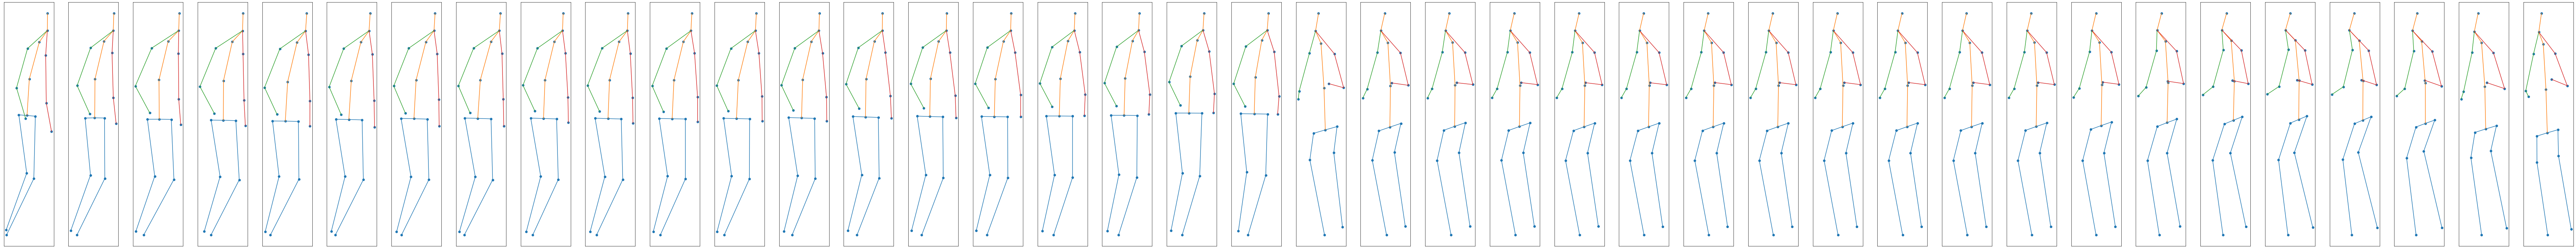

In [311]:
visualize_frames(full_predictions[0].numpy(), dynamic_joints_only=True, num_frames_to_visualize=40, path_to_save='../actionswitching', save_gif=True)

## Loss Graphs

In [86]:
repeated_frames_jointloss = [1934934784.0] * 50
repeated_frames_mse = [76.37667083740234] * 50

In [83]:
bilstm_shortterm_mse = [39972.1171875, 9662.1279296875, 9557.513671875, 8060.86376953125, 6000.4658203125, 3248.993896484375, 1915.6424560546875, 
                        1640.5806884765625, 1470.27783203125, 1292.015869140625, 1215.55322265625, 1157.8892822265625, 1127.542236328125, 
                        1089.7706298828125, 1067.3067626953125, 1041.8245849609375, 1008.3980712890625, 1001.1904907226562, 965.0206909179688, 
                        948.8802490234375, 925.1904296875, 899.7987670898438, 878.2308959960938, 860.2780151367188, 843.8549194335938, 
                        820.1718139648438, 799.8905639648438, 791.6035766601562, 781.1383056640625, 761.3648681640625, 745.1781005859375, 
                        737.6052856445312, 729.0819091796875, 722.0947875976562, 705.3606567382812, 693.6061401367188, 683.2760009765625, 
                        679.8379516601562, 675.9973754882812, 660.5773315429688, 651.9466552734375, 644.8717651367188, 637.4879760742188, 
                        628.8317260742188, 623.5604248046875, 621.2945556640625, 609.3187255859375, 606.8350219726562, 601.6840209960938, 
                        592.1245727539062]

bilstm_shortterm_jointloss = [8030857.0, 2944650.75, 2735703.0, 2390411.25, 2053649.25, 1851239.0, 1779005.875, 1752736.125, 1726929.875, 
                              1708539.625, 1691347.5, 1677874.375, 1668314.25, 1661999.0, 1656328.125, 1652629.625, 1648656.75, 1643184.5, 
                              1640706.75, 1634570.125, 1631464.625, 1645755.625, 1632908.0, 1628122.625, 1623936.5, 1623531.125, 1619204.625, 
                              1615739.875, 1611921.5, 1611097.0, 1608972.75, 1606715.5, 1604314.375, 1602378.25, 1601695.0, 1598188.125, 
                              1598009.75, 1596933.0, 1596420.0, 1594197.0, 1593367.25, 1592830.625, 1589303.125, 1589749.875, 1587478.125, 
                              1587477.125, 1585275.625, 1584213.0, 1582700.0, 1582699.25]

bilstm_longterm_mse = [129456.890625, 32532.337890625, 12333.4462890625, 9825.7705078125, 9668.0078125, 9663.15234375, 9663.60546875, 
                       9663.7705078125, 9664.1259765625, 9664.2490234375, 9664.228515625, 9648.19140625, 9432.9912109375, 8675.216796875, 
                       8376.7021484375, 8011.40478515625, 7613.95947265625, 7117.20654296875, 5671.51708984375, 4803.0859375, 4295.638671875, 
                       3946.888427734375, 3632.318359375, 3292.464599609375, 3055.00927734375, 2831.618408203125, 2708.858154296875, 
                       2496.704345703125, 2490.7646484375, 2325.746826171875, 2290.864501953125, 2220.375, 2620.7236328125, 2327.6513671875, 
                       2173.016357421875, 2111.98193359375, 2124.294921875, 2078.8681640625, 2003.4420166015625, 1950.3900146484375, 
                       1899.65576171875, 1881.484619140625, 1904.701171875, 1873.95068359375, 1894.534423828125, 1883.490234375, 
                       1855.67919921875, 1785.4801025390625, 1818.37060546875, 1827.5921630859375]

bilstm_longterm_jointloss = [44041408.0, 11169394.0, 4341214.0, 3510733.0, 3457672.0, 3283360.0, 3044417.0, 2916329.0, 2828620.0, 2754300.75, 
                             2684467.25, 2609697.0, 2532157.5, 2445991.5, 2283954.75, 1760202.625, 1445350.0, 1254603.0, 1108365.375, 
                             1030306.9375, 945532.875, 874087.3125, 864022.125, 815649.875, 772034.3125, 747319.8125, 729982.875, 729793.5, 
                             706952.4375, 686524.875, 706727.75, 674917.6875, 670440.25, 677658.4375, 666228.625, 662204.3125, 667653.0625, 
                             661693.75, 641843.3125, 644113.3125, 627768.125, 622408.75, 612087.9375, 621550.875, 610700.9375, 602532.4375, 
                             600024.8125, 595795.5, 589662.9375, 579068.375]

dlinear_shortterm_jointloss = [38866924.0, 37808192.0, 36769160.0, 35747928.0, 34743632.0, 33755108.0, 32781842.0, 31824008.0, 30881338.0,
                               29954244.0, 29041632.0, 28143842.0, 27261430.0, 26394358.0, 25542088.0, 24704754.0, 23882578.0, 23075334.0, 
                               22282876.0, 21505338.0, 20743246.0,19996194.0, 19263816.0, 18546546.0, 17844066.0, 17156418.0, 16483959.0, 
                               15826539.0, 15184147.0, 14556672.0, 13943855.0, 13346205.0, 12763429.0, 12195248.0, 11642126.0, 11104069.0, 
                               10580688.0, 10072091.0, 9578409.0, 9099493.0, 8635403.0, 8186002.5, 7751285.5, 7331332.0, 6926126.0, 6535633.0, 
                               6159771.0, 5798731.5, 5452284.5, 5120512.0]

dlinear_shortterm_mse = [228664.28125, 222436.328125, 216323.015625, 210316.46875, 204409.34375, 198591.375, 192865.546875,
                         187232.421875, 181686.90625, 176230.0, 170861.78125, 165582.15625, 160391.796875, 155290.125, 150275.15625,
                         145347.953125, 140512.109375, 135765.125, 131102.25, 126527.4921875, 122042.0078125, 117646.75, 113340.2421875,
                         109118.8828125, 104985.078125, 100939.5546875, 96986.296875, 93120.5, 89339.3984375, 85646.765625, 82043.0703125,
                         78525.1953125, 75094.921875, 71753.5390625, 68500.953125, 65335.06640625, 62254.671875, 59262.19140625, 56356.79296875,
                         53538.98046875, 50807.234375, 48163.58984375, 45606.52734375, 43136.5390625, 40753.58984375, 38457.0390625, 36244.9921875,
                         34118.76171875, 32077.74609375, 30124.75]

dlinear_longterm_jointloss = [78104592.0, 76690384.0, 75294344.0, 73915208.0, 72551888.0, 71204040.0, 69870736.0, 68551296.0, 67245576.0, 
                              65953552.0, 64674648.0, 63409516.0, 62157824.0, 60919204.0, 59694088.0, 58482188.0, 57283484.0, 56097884.0, 
                              54925988.0, 53766804.0, 52620996.0, 51488672.0, 50369476.0, 49263380.0, 48170524.0, 47091352.0, 46025224.0, 
                              44972088.0, 43932116.0, 42905200.0, 41892104.0, 40892176.0, 39905204.0, 38931388.0, 37971188.0, 37023952.0, 
                              36089720.0, 35168884.0, 34261204.0, 33366102.0, 32484478.0, 31616468.0, 30761346.0, 
                              29919604.0, 29091010.0, 28274908.0, 27471918.0, 26682190.0, 25906102.0, 25143632.0]

dlinear_longterm_mse = [229632.765625, 225473.359375, 221369.984375, 217315.265625, 213304.265625, 209339.890625, 205418.578125, 201539.078125, 
                        197699.796875, 193900.71875, 190141.640625, 186422.25, 182741.09375, 179098.703125, 175495.640625, 171932.265625, 
                        168406.796875, 164920.125, 161473.328125, 158064.953125, 154695.65625, 151365.0625, 148074.296875, 144822.4375, 
                        141609.53125, 138436.875, 135302.734375, 132206.71875, 129149.078125, 126129.7265625, 123150.09375, 120209.28125, 
                        117306.890625, 114443.71875, 111620.3125, 108835.203125, 106088.9609375, 103381.234375, 100711.5, 98079.9296875, 
                        95488.6484375, 92935.1328125, 90419.984375, 87944.5, 85508.2734375, 83110.8203125, 80750.7421875, 78429.0, 76146.5234375, 
                        73902.984375]

In [96]:
updated_model1 = [59019.175,13700.821,9166.8359,9167.5547,9171.0127,9172.0645,9167.1943,9169.8086,9170.7080,9169.0381,9168.1006,9168.1094,
          7062.5073,4279.8960,3240.3533,2541.7122,2096.8037,1879.3956,1744.1650,1695.6102,1639.2594,1592.5142,1563.2732,1510.9652,
          1523.4789,1477.1345,1428.3448,1342.5500,1332.5608,1291.3834,1245.4474,1237.5807,1213.4785,1191.1219,1209.7441,1194.6100,
          1183.3473,1164.1637,1162.3896,1139.7070,1148.4924,1127.1067,1128.9316,1130.0120,1129.7628,1117.1649,1103.5100,1071.4777,
          1092.5253,1089.8733]

updated_model2 = [17976228.00,3122763.000,3120487.500,2502910.750,1530147.250,1103247.375,936651.6875,820268.9375,682381.8125,675630.6250,
                  622077.6875,572122.7500,536325.7500,512153.6250,501007.8750,478800.1250,480210.0625,465354.9688,442759.6562,445068.6875,
                  433059.0625,429206.7188,425577.1250,423746.4375,413766.5000,413210.0312,409428.8750,404981.9375,398897.5625,398801.6250,
                  400197.3750,395765.8438,388967.3750,387749.5625,387340.4375,435223.4688,400814.3438,386577.1875,385043.8125,378817.1250,
                  371294.3750,371977.8750,373542.4688,367492.6562,368977.2812,359159.9062,358530.8125,364119.2812,351454.9688,355003.5938]

updated_model7 = [58254.2891,16259.0293,16250.0352,16251.8799,16254.5840,16256.1006,16254.4785,16256.3564,9610.7588,8292.6221,
                  6441.1592,4685.8784,3466.3032,2728.6389,2335.3938,2110.7183,1972.5485,1904.0519,1833.7854,1752.9785,1706.1407,
                  1659.1749,1610.5242,1568.5309,1529.7449,1471.3618,1376.5271,1351.6282,1305.8055,1283.8287,1274.2395,1249.2361,
                  1245.6128,1206.4048,1212.0305,1205.6899,1196.7289,1173.9799,1158.6006,1143.4628,1141.2421,1116.8160,1113.2703,
                  1147.1864,1084.9094,1104.8263,1092.0719,1097.7781,1059.5579,1051.3340]

updated_model8 = [17785726.000,3120860.0000,3118420.2500,3115978.0000,3115074.7500,3115733.7500,3115602.7500,3115711.7500,
                  3115436.0000,3115056.2500,3115270.5000,3115914.5000,3053884.2500,2140719.2500,1264744.6250,921264.2500,
                  824658.2500,777987.7500,716022.6250,687886.9375,714582.9375,648912.6250,618507.1250,579742.1250,567009.6250,
                  548883.3125,536426.0000,520121.4688,516462.3750,510375.2812,508834.6250,500701.6562,493233.4688,510297.7188,
                  466139.0000,457823.9688,450947.6250,430911.8125,427125.2812,424337.8125,421899.0625,416343.1250,419992.6250,
                  419557.6250,413002.1562,408207.3125,407917.9062,398803.0938,399449.4375,396078.1875]

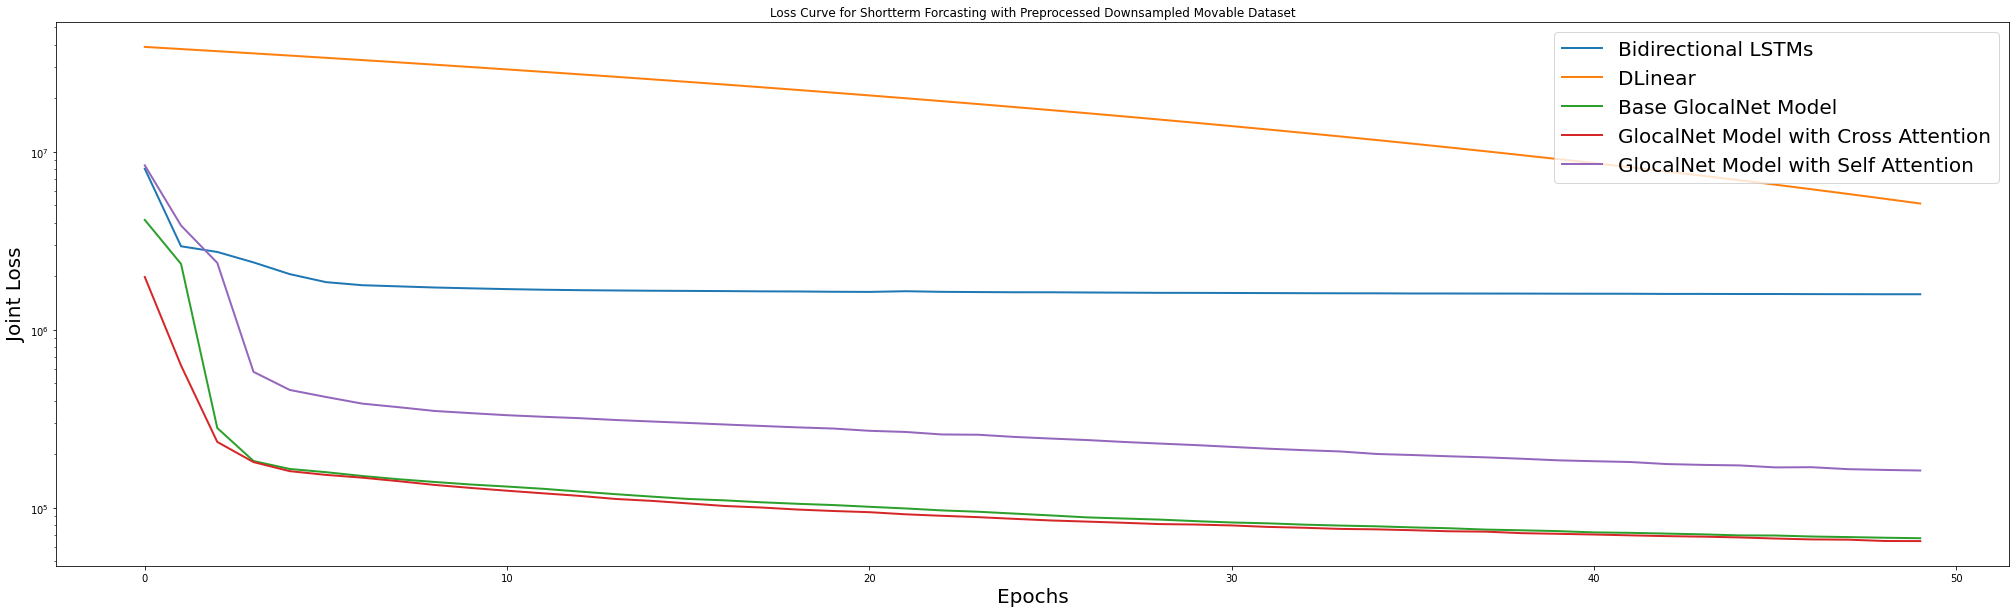

In [116]:
fig = plt.figure(figsize=(35,10))

#plt.subplot(1,2,1)
#plt.plot(repeated_frames_mse, label='Shortterm Forcasting using Repeated Frames and \nPreprocessed Downsampled Movable Dataset')
#plt.plot(bilstm_shortterm_mse, label='Shortterm Forcasting using Bidirectional LSTM with \nPreprocessed Downsampled Movable Dataset')
#plt.plot(dlinear_shortterm_mse, label='Shortterm Forcasting with DLinear and \nPreprocessed Downsampled Movable Dataset')
#plt.plot(reloaded_model3_history, label='Shortterm Forcasting with \nPreprocessed Downsampled Movable Dataset')
#plt.plot(reloaded_model5_history, label='Shortterm Forcasting with Self Attention and \nPreprocessed Downsampled Movable Dataset')
#plt.plot(history_model18.history['loss'], label='Shortterm Forcasting with Cross Attention and \nPreprocessed Downsampled Movable Dataset')

#plt.xlabel('Epochs')
#plt.ylabel('MSE Loss')
#plt.title('Loss Curve for Shortterm Forcasting')
#plt.yscale("log")
#plt.legend()

#plt.subplot(1,2,2)
#plt.plot(repeated_frames_jointloss, label='Repeated Frames')
plt.plot(bilstm_shortterm_jointloss, label='Bidirectional LSTMs',linewidth=2.0)
plt.plot(dlinear_shortterm_jointloss, label='DLinear',linewidth=2.0)
plt.plot(reloaded_model6_history, label='Base GlocalNet Model',linewidth=2.0)
plt.plot(reloaded_model4_history, label='GlocalNet Model with Cross Attention',linewidth=2.0)
plt.plot(reloaded_model17_history, label='GlocalNet Model with Self Attention',linewidth=2.0)

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Joint Loss', fontsize=20)
plt.title('Loss Curve for Shortterm Forcasting with Preprocessed Downsampled Movable Dataset')
plt.yscale("log")
plt.legend(prop={'size':'20'})

plt.savefig('./Shortterm_loss_curve', bbox_inches='tight')
plt.show()

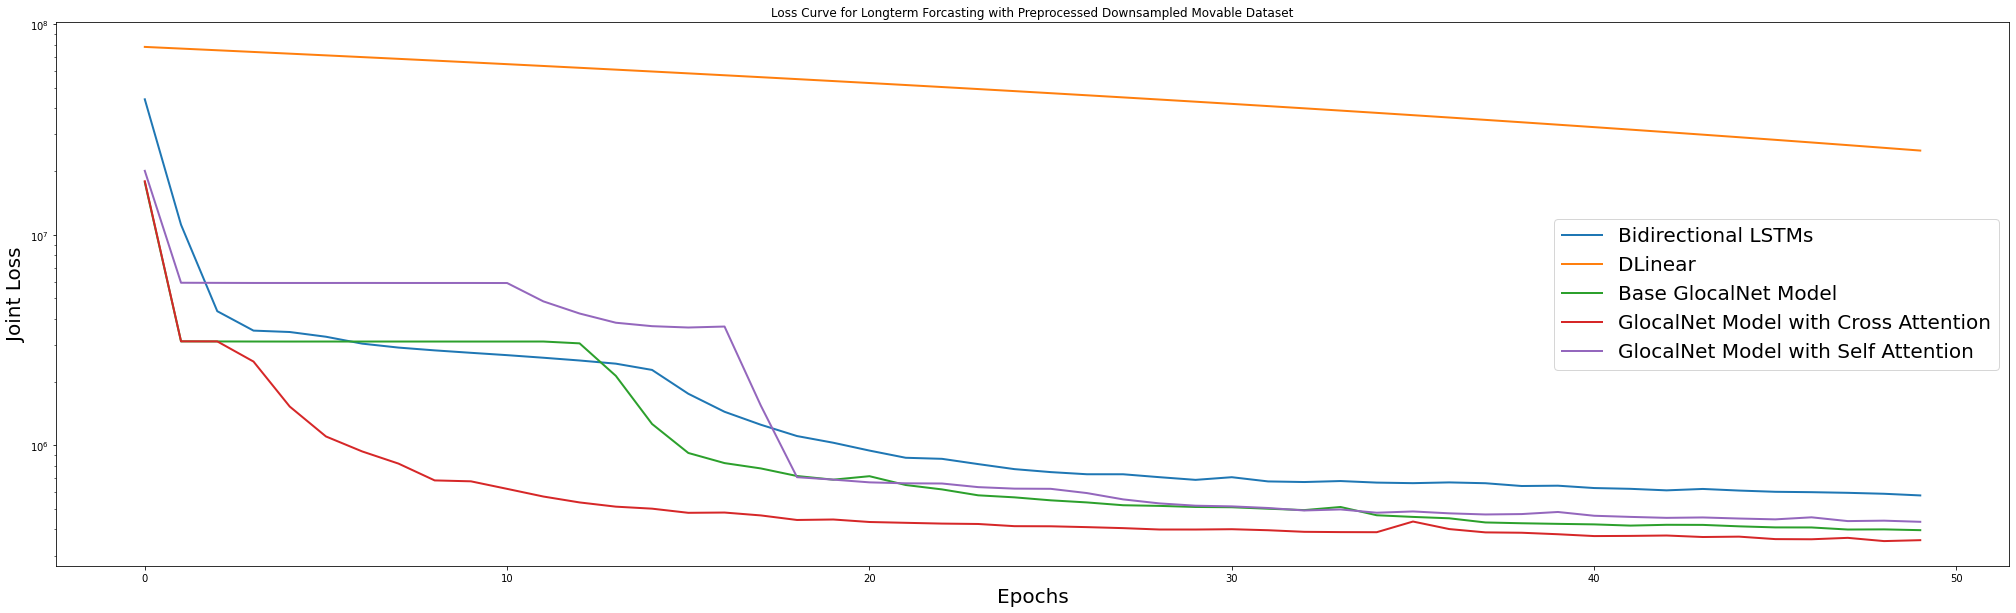

In [115]:
fig = plt.figure(figsize=(35,10))

#plt.subplot(1,2,1)
#plt.plot(bilstm_longterm_mse, label='Longterm Forcasting using Bidirectional LSTM with \nPreprocessed Downsampled Movable Dataset')
#plt.plot(dlinear_longterm_mse, label='Longterm Forcasting with DLinear and \nPreprocessed Downsampled Movable Dataset')
#plt.plot(updated_model1, label='Longterm Forcasting with \nPreprocessed Downsampled Movable Dataset')
#plt.plot(updated_model7, label='Longterm Forcasting with Self Attention and \nPreprocessed Downsampled Movable Dataset')
#plt.plot(reloaded_model9_history, label='Longterm Forcasting with Cross Attention and \nPreprocessed Downsampled Movable Dataset')

#plt.xlabel('Epochs')
#plt.ylabel('MSE Loss')
#plt.title('Loss Curve for Longterm Forcasting')
#plt.yscale("log")
#plt.legend()

#plt.subplot(1,2,2)
plt.plot(bilstm_longterm_jointloss, label='Bidirectional LSTMs',linewidth=2.0)
plt.plot(dlinear_longterm_jointloss, label='DLinear',linewidth=2.0)
plt.plot(updated_model8, label='Base GlocalNet Model',linewidth=2.0)
plt.plot(updated_model2, label='GlocalNet Model with Cross Attention',linewidth=2.0)
plt.plot(reloaded_model10_history, label='GlocalNet Model with Self Attention',linewidth=2.0)

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Joint Loss', fontsize=20)
plt.title('Loss Curve for Longterm Forcasting with Preprocessed Downsampled Movable Dataset')
plt.yscale("log")
plt.legend(prop={'size':'20'})

plt.savefig('./Longterm_loss_curve', bbox_inches='tight')
plt.show()

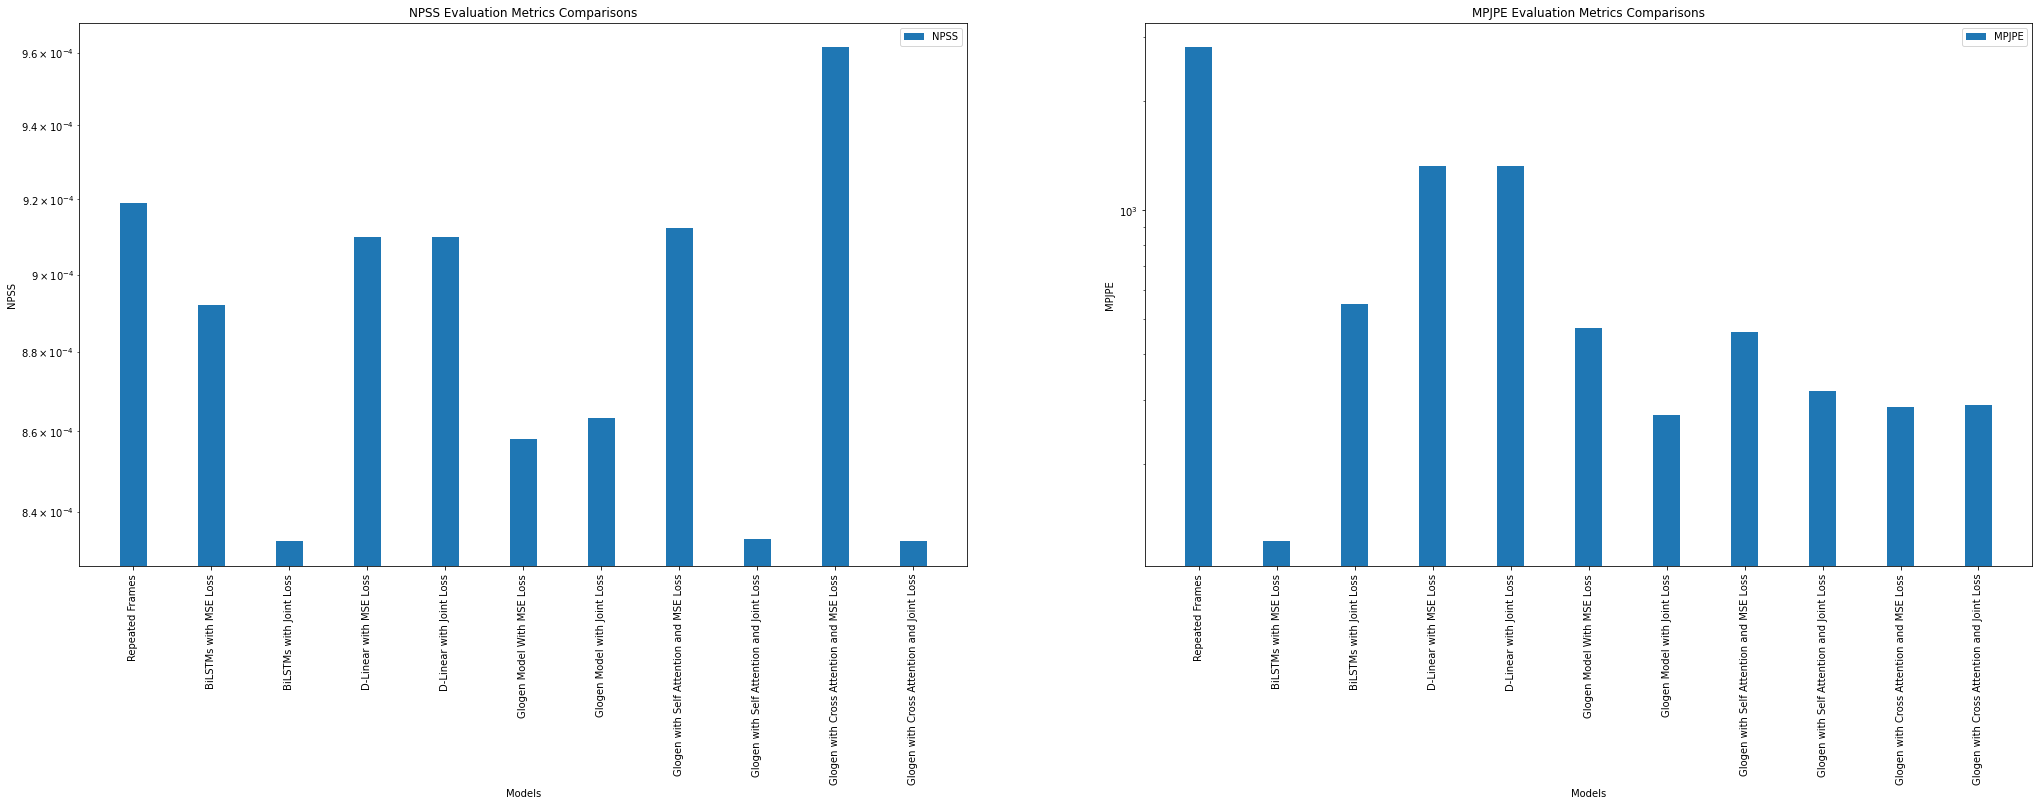

In [55]:
fig = plt.figure(figsize=(35,10))

shortterm_names = ['Repeated Frames', 'BiLSTMs with MSE Loss', 'BiLSTMs with Joint Loss', 
                   'D-Linear with MSE Loss', 'D-Linear with Joint Loss', 'Glogen Model With MSE Loss', 
                   'Glogen Model with Joint Loss', 'Glogen with Self Attention and MSE Loss', 'Glogen with Self Attention and Joint Loss', 
                   'Glogen with Cross Attention and MSE Loss', 'Glogen with Cross Attention and Joint Loss']

shortterm_npss_metric = [0.000919, 0.000892, 0.0008328, 0.0009099661781850998, 0.0009099578296896899, 0.000858070104530992, 
                         0.0008631691767778326, 0.0009124066245921014, 0.0008333297126929977, 0.0009615646726360141, 0.000832904184123525]

shortterm_mpjpe_metric = [2808.38, 121.980, 551.95, 1323.8010539798945, 1323.53612162764, 472.972043326752, 272.3621738376875, 
                          460.2155117324885, 317.07122262458523, 286.9667480626736, 290.8383635844748]

plt.subplot(1,2,1)
plt.bar(shortterm_names, shortterm_npss_metric, width=0.35, label='NPSS')
plt.xlabel('Models')
plt.ylabel('NPSS')
plt.title('NPSS Evaluation Metrics Comparisons')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend()

plt.subplot(1,2,2)
plt.bar(shortterm_names, shortterm_mpjpe_metric, width=0.35, label='MPJPE')
plt.xlabel('Models')
plt.ylabel('MPJPE')
plt.title('MPJPE Evaluation Metrics Comparisons')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend()

plt.savefig('./Shortterm_evaluation_metric_comparison', bbox_inches='tight')
plt.show()

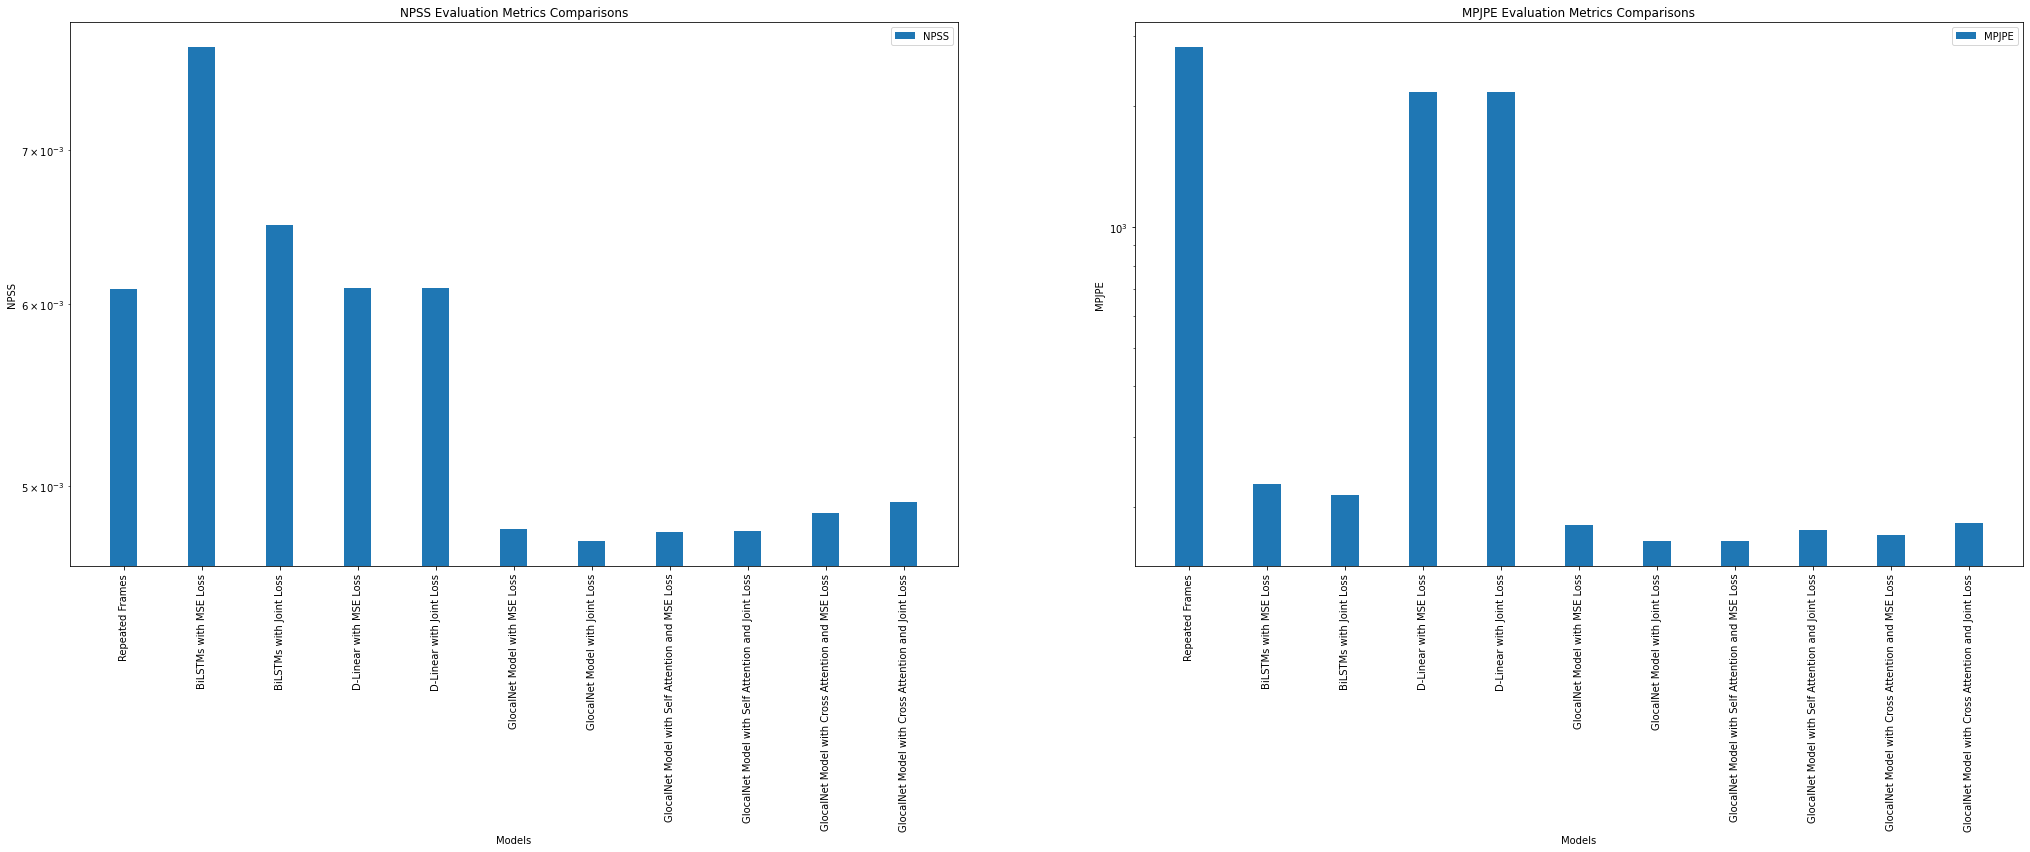

In [56]:
fig = plt.figure(figsize=(35,10))

longterm_names = ['Repeated Frames', 'BiLSTMs with MSE Loss', 'BiLSTMs with Joint Loss', 'D-Linear with MSE Loss', 'D-Linear with Joint Loss', 
                  'GlocalNet Model with MSE Loss', 'GlocalNet Model with Joint Loss', 'GlocalNet Model with Self Attention and MSE Loss', 
                  'GlocalNet Model with Self Attention and Joint Loss', 'GlocalNet Model with Cross Attention and MSE Loss', 
                  'GlocalNet Model with Cross Attention and Joint Loss']

longterm_npss_metric = [0.00609, 0.0077633, 0.006492, 0.006095467133791247, 0.006095270941862366, 0.0047904873586968755, 0.004730936595272887, 
                        0.004775812125455487, 0.004780885647145856, 0.004867499639368529, 0.004919473291519054]

longterm_mpjpe_metric = [2808.32, 228.288, 214.215, 2166.3537888785863, 2167.0434049482533, 180.19750662666505, 164.50535776591974, 
                         165.16814132455374, 174.94902925491334, 170.72654463145426, 182.76067079070967]

plt.subplot(1,2,1)
plt.bar(longterm_names, longterm_npss_metric, width=0.35, label='NPSS')
plt.xlabel('Models')
plt.ylabel('NPSS')
plt.title('NPSS Evaluation Metrics Comparisons')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend()

plt.subplot(1,2,2)
plt.bar(longterm_names, longterm_mpjpe_metric, width=0.35, label='MPJPE')
plt.xlabel('Models')
plt.ylabel('MPJPE')
plt.title('MPJPE Evaluation Metrics Comparisons')
plt.yscale('log')
plt.xticks(rotation=90)
plt.legend()

plt.savefig('./Longterm_evaluation_metric_comparison', bbox_inches='tight')
plt.show()

## Results Visualization

In [225]:
if not os.path.exists('./Results'):
    os.makedirs('./Results')
    
if not os.path.exists('./Results/history'):
    os.makedirs('./Results/history')
    
if not os.path.exists('./Results/predictions'):
    os.makedirs('./Results/predictions')

In [187]:
experiment = ['Base Implementation with MSE Loss','Base Implementation with Joint Loss','Base Implementation with Self Attention and MSE Loss',
              'Base Implementation with Self Attention and Joint Loss','Base Implementation with Cross Attention and MSE Loss',
              'Base Implementation with Cross Attention and Joint Loss']
npss_values_lt = [glocal_model1_npss, glocal_model2_npss, glocal_model7_npss, glocal_model8_npss, glocal_model9_npss, glocal_model10_npss]
mpjpe_values_lt = [glocal_model1_mpjpe, glocal_model2_mpjpe, glocal_model7_mpjpe, glocal_model8_mpjpe, glocal_model9_mpjpe, glocal_model10_mpjpe]

metric_lt_df = pd.DataFrame(list(zip(experiment, npss_values_lt, mpjpe_values_lt)), columns=['Experiment', 'NPSS', 'MPJPE'])
metric_lt_df = metric_lt_df.set_index('Experiment')
metric_lt_df

,NPSS,MPJPE
Experiment,,
Base Implementation with MSE Loss,0.004947,188.308449
Base Implementation with Joint Loss,0.004635,180.797794
Base Implementation with Self Attention and MSE Loss,0.004879,185.879171
Base Implementation with Self Attention and Joint Loss,0.004841,178.251692
Base Implementation with Cross Attention and MSE Loss,0.005593,222.421770
Base Implementation with Cross Attention and Joint Loss,0.004914,183.489090


In [188]:
experiment_shortterm = ['Glogen with MSE Loss', 'Glogen with Joint Loss', 'Glogen with Self Attention and MSE Loss', 
              'Glogen with Cross Attention and Joint Loss']
npss_values_lt_shortterm = [glocal_model3_npss, glocal_model4_npss, glocal_model5_npss, glocal_model6_npss]
mpjpe_values_lt_shortterm = [glocal_model3_mpjpe, glocal_model4_mpjpe, glocal_model5_mpjpe, glocal_model6_mpjpe]

metric_lt_df_shortterm = pd.DataFrame(list(zip(experiment_shortterm, npss_values_lt_shortterm, mpjpe_values_lt_shortterm)), 
                                      columns=['Experiment', 'NPSS', 'MPJPE'])
metric_lt_df_shortterm = metric_lt_df_shortterm.set_index('Experiment')
metric_lt_df_shortterm

,NPSS,MPJPE
Experiment,,
Glogen with MSE Loss,0.000851,480.804048
Glogen with Joint Loss,0.000458,546.908984
Glogen with Self Attention and MSE Loss,0.001342,691.568854
Glogen with Cross Attention and Joint Loss,0.000703,577.332364


In [190]:
with pd.ExcelWriter('./Results/Evaluation_metric_results.xlsx') as writer:
    metric_lt_df.to_excel(writer, sheet_name='Long Term Predictions')
    metric_lt_df_shortterm.to_excel(writer, sheet_name='Short Term Predictions')

In [70]:
reloaded_model1_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model1.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())
reloaded_model2_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model2.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())
reloaded_model3_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model3.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())
reloaded_model4_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model4.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())
reloaded_model5_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model5.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())
reloaded_model6_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model6.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())
reloaded_model7_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model7.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())
reloaded_model8_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model8.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())
reloaded_model9_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model9.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())
reloaded_model10_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model10.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())

Reloading the file: ./Results/history/history_model1.csv in a dictionary Done.
Reloading the file: ./Results/history/history_model2.csv in a dictionary Done.
Reloading the file: ./Results/history/history_model3.csv in a dictionary Done.
Reloading the file: ./Results/history/history_model4.csv in a dictionary Done.
Reloading the file: ./Results/history/history_model5.csv in a dictionary Done.
Reloading the file: ./Results/history/history_model6.csv in a dictionary Done.
Reloading the file: ./Results/history/history_model7.csv in a dictionary Done.
Reloading the file: ./Results/history/history_model8.csv in a dictionary Done.
Reloading the file: ./Results/history/history_model9.csv in a dictionary Done.
Reloading the file: ./Results/history/history_model10.csv in a dictionary Done.


In [74]:
reloaded_model17_history = list(manage_model_history(save_filepath = None, reload_filepath='./Results/history/history_model17.csv', history=None, reload_filetype='csv', model_name='', 
                     save_as_csv=False, save_as_pickle=False)['loss'].values())

Reloading the file: ./Results/history/history_model17.csv in a dictionary Done.


In [64]:
def manage_model_history(save_filepath, reload_filepath, history, reload_filetype = 'csv', model_name = '', 
                         save_as_pickle = True, save_as_csv = True):
    """_
    The function tries to save the History variable of any Tensorflow model to the given file type or reload back to the 
    history variable.
    """
    
    #assert reload_filetype in ['pickle', 'csv'], 'Only Pickle and CSV formats are available'
    #assert len(model_name) > 0, 'Model Name is Compulsory to pass'
    #assert save_as_csv or save_as_pickle, 'Please select the type in which to save the history'
    
    #Saving the History as a Pickle Object
    if save_as_pickle:
        path = '{}/history_{}'.format(save_filepath, model_name)
        with open(path, mode='wb') as file:
            pickle.dump(history.history, file)
        print('Saving the History for model: {} in the Pickle Format Done.'.format(model_name))
            
    #Saving the History as a CSV file
    if save_as_csv:
        path = '{}/history_{}.csv'.format(save_filepath, model_name)
        with open(path, mode = 'wb') as file:
            pd.DataFrame(history.history).to_csv(file)
        print('Saving the History for model: {} in the CSV Format Done.\n'.format(model_name))
    
    #Reloading the history from the File 
    if reload_filepath != None:
        history = None
        if reload_filetype == 'pickle':
            with open(reload_filepath, "rb") as file_pi:
                history = pickle.load(file_pi)
        elif reload_filetype == 'csv':
            history = pd.read_csv(reload_filepath).to_dict()
        print('Reloading the file: {} in a dictionary Done.'.format(reload_filepath))
        return history

In [58]:
def manage_predictions(filepath, predictions, save = True, model_name = ''):
    """
    The function tries to save the Predictions of the Tensorflow models to the given file type or reload back to the 
    variable.
    """
    assert len(model_name) > 0, 'Model Name is Compulsory to pass'
    assert predictions is not None, 'Predictions cannot be Empty'
    assert len(filepath) > 0, 'File Path should not be Empty'
    
    #Saving the Predictions
    if save:
        path = '{}/predictions_{}.npy'.format(filepath, model_name)
        np.save(path, predictions)
        print('Saving the predictions for Model: {} Done'.format(model_name)) 
        
    #Reloading the Predictions
    if not save:
        path = '{}/predictions_{}.npy'.format(filepath, model_name)
        pred = np.load(path)
        print('Reloading the Predictions Done')
        return pred

In [232]:
manage_model_history('./Results/history', reload_filepath = None, history = history_model1, model_name = 'model1')
manage_model_history('./Results/history', reload_filepath = None, history = history_model2, model_name = 'model2')
manage_model_history('./Results/history', reload_filepath = None, history = history_model3, model_name = 'model3')
manage_model_history('./Results/history', reload_filepath = None, history = history_model4, model_name = 'model4')
manage_model_history('./Results/history', reload_filepath = None, history = history_model5, model_name = 'model5')
manage_model_history('./Results/history', reload_filepath = None, history = history_model6, model_name = 'model6')
manage_model_history('./Results/history', reload_filepath = None, history = history_model7, model_name = 'model7')
manage_model_history('./Results/history', reload_filepath = None, history = history_model8, model_name = 'model8')
manage_model_history('./Results/history', reload_filepath = None, history = history_model9, model_name = 'model9')
manage_model_history('./Results/history', reload_filepath = None, history = history_model10, model_name = 'model10')
manage_model_history('./Results/history', reload_filepath = None, history = history_model11, model_name = 'model11')

Saving the History for model: model1 in the Pickle Format Done.
Saving the History for model: model1 in the CSV Format Done.

Saving the History for model: model2 in the Pickle Format Done.
Saving the History for model: model2 in the CSV Format Done.

Saving the History for model: model3 in the Pickle Format Done.
Saving the History for model: model3 in the CSV Format Done.

Saving the History for model: model4 in the Pickle Format Done.
Saving the History for model: model4 in the CSV Format Done.

Saving the History for model: model5 in the Pickle Format Done.
Saving the History for model: model5 in the CSV Format Done.

Saving the History for model: model6 in the Pickle Format Done.
Saving the History for model: model6 in the CSV Format Done.

Saving the History for model: model7 in the Pickle Format Done.
Saving the History for model: model7 in the CSV Format Done.

Saving the History for model: model8 in the Pickle Format Done.
Saving the History for model: model8 in the CSV Format

In [228]:
manage_predictions('./Results/predictions', glocal_model1_pred, save = True, model_name='model1')
manage_predictions('./Results/predictions', glocal_model2_pred, save = True, model_name='model2')
manage_predictions('./Results/predictions', glocal_model3_pred, save = True, model_name='model3')
manage_predictions('./Results/predictions', glocal_model4_pred, save = True, model_name='model4')
manage_predictions('./Results/predictions', glocal_model5_pred, save = True, model_name='model5')
manage_predictions('./Results/predictions', glocal_model6_pred, save = True, model_name='model6')
manage_predictions('./Results/predictions', glocal_model7_pred, save = True, model_name='model7')
manage_predictions('./Results/predictions', glocal_model8_pred, save = True, model_name='model8')
manage_predictions('./Results/predictions', glocal_model9_pred, save = True, model_name='model9')
manage_predictions('./Results/predictions', glocal_model10_pred, save = True, model_name='model10')
manage_predictions('./Results/predictions', glocal_model11_pred, save = True, model_name='model11')

Saving the predictions for Model: model1 Done
Saving the predictions for Model: model2 Done
Saving the predictions for Model: model3 Done
Saving the predictions for Model: model4 Done
Saving the predictions for Model: model5 Done
Saving the predictions for Model: model6 Done
Saving the predictions for Model: model7 Done
Saving the predictions for Model: model8 Done
Saving the predictions for Model: model9 Done
Saving the predictions for Model: model10 Done
Saving the predictions for Model: model11 Done


## Visualization

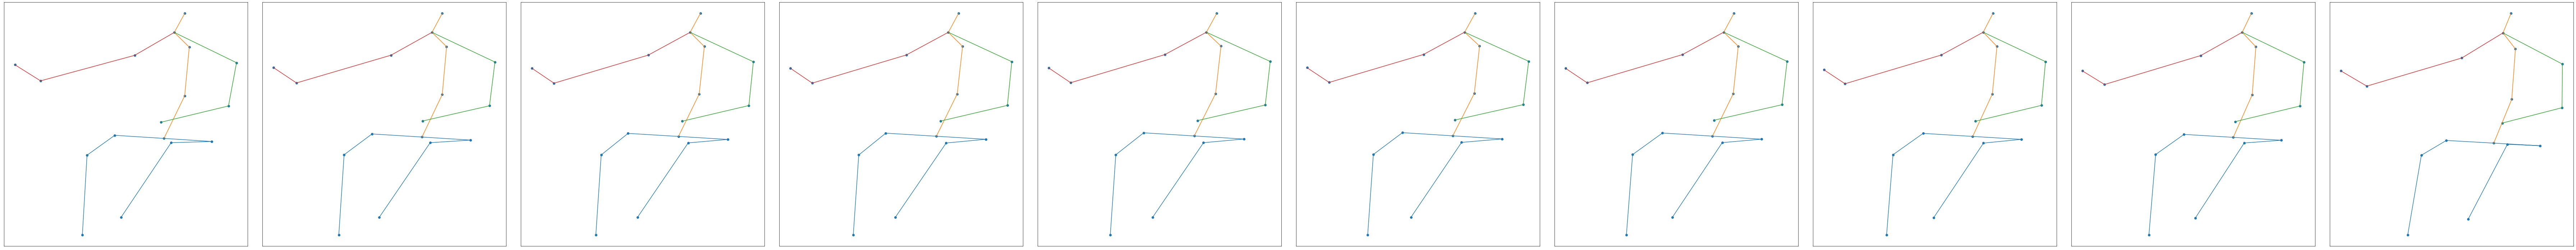

In [183]:
visualize_frames(glocal_model4_pred[3000], dynamic_joints_only=True)

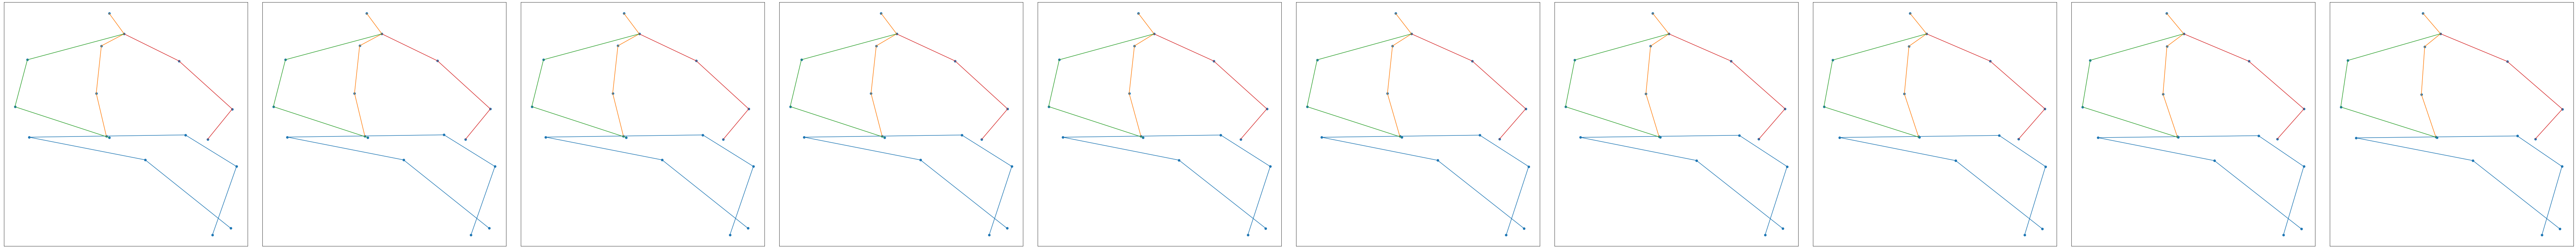

In [184]:
visualize_frames(preprocessed_downsampled_dataY_shortterm_movable[3000], dynamic_joints_only=True)

# References

[1] https://github.com/una-dinosauria/3d-pose-baseline/blob/master/src/data_utils.py

[2] Gopalakrishnan, Anand, et al. "A neural temporal model for human motion prediction." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019

[3] https://github.com/cr7anand/neural_temporal_models